In [104]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [105]:
import pandas as pd
import numpy as np
import random, os

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

In [106]:
!%%capture
!pip install koreanize-matplotlib
import koreanize_matplotlib

/bin/bash: line 1: fg: no job control


In [107]:
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    tf.config.threading.set_intra_op_parallelism_threads(1)
    tf.config.threading.set_inter_op_parallelism_threads(1)

set_seed(42)

In [108]:
df = pd.read_csv('/content/drive/MyDrive/LIKELION_데이터분석/datathon/final.csv')

In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     300 non-null    int64  
 1   TIME           300 non-null    object 
 2   원/달러환율         300 non-null    float64
 3   한국 장기 시장 금리    291 non-null    float64
 4   미국 장기 시장 금리    300 non-null    float64
 5   중국 장기 시장 금리    132 non-null    float64
 6   한국 단기 시장 금리    300 non-null    float64
 7   미국 단기 시장 금리    299 non-null    float64
 8   중국 단기 시장 금리    299 non-null    float64
 9   전체 수출 총액       300 non-null    int64  
 10  미국 수출 총액       300 non-null    int64  
 11  중국 수출 총액       300 non-null    int64  
 12  전체 수입 총액       300 non-null    int64  
 13  미국 수입 총액       300 non-null    int64  
 14  중국 수입 총액       300 non-null    int64  
 15  소득 교역 조건 지수    300 non-null    float64
 16  해외 직접 투자 금액    300 non-null    int64  
 17  경제 심리 지수       264 non-null    float64
 18  한국 기준 금리  

# CNN
create_sequences()를 통해서 타겟값은 원/달러환율로 넣었지만, `X[i:i+12] → y[i+12]` 으로 12개월의 이력으로 1개월 후 에측이라는 구조 생성

| 실험코드 | 변수 집합   | 변수 선택 방식                                        | 타깃           |
| ---- | ------- | ----------------------------------------------- | ------------ |
| A-1  | 31개 전체  | 전 변수 사용                                         | 원/달러환율 |
| A-2  | 31개 전체  | L1 정규화 기반 선택 (Lasso)                            | 원/달러환율 |
| A-3  | 31개 전체  | Feature Importance 기반 선택 (RandomForest) | 원/달러환율 |
| A-4  | 31개 전체  | Permutation Importance 기반 선택 | 원/달러환율 |
| B-1  | 유효한 20개 | 전 변수 사용                                         | 원/달러환율 |
| B-2  | 유효한 20개 | L1 정규화 기반 선택 (Lasso)                            | 원/달러환율 |
| B-3  | 유효한 20개 | Feature Importance 기반 선택 (RandomForest) | 원/달러환율 |
| B-4  | 유효한 20개  | Permutation Importance 기반 선택 | 원/달러환율 |



## A-1

In [110]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# 0. 시퀀스 생성 함수
def create_sequences(X, y, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# 1. 변수 정의
features = ['경제 심리 지수', '한국 기준 금리', '미국 기준 금리', '한국 외환 보유액',
            '한국 실업률', '미국 실업률', '한국 주가지수', '미국 주가지수', 'WTI 유가', '두바이 유가',
            'Brent 유가', '천연가스 가격', '유연탄 가격', '철광석 가격', '구리 가격',
            '알루미늄 가격', '니켈 가격', '아연 가격', '금 가격', '대두 가격', '외국인 투자 금액',
            '옥수수 가격', '소맥 가격', '원당 가격', '원면 가격',
            '한국 경상수지', '한국 인플레이션율', '인플레이션 격차',
            'M2', '실질GDP성장률', 'vix']

# 2. 결측치 처리 및 타깃 설정
df_filled = df.copy()
df_filled = df_filled.interpolate(method='linear')
df_filled = df_filled.ffill().bfill()

X = df_filled[features].values
y = df_filled["원/달러환율"].values

# 3. 정규화 및 시퀀스 생성
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_seq, y_seq = create_sequences(X_scaled, y, time_steps=12)

# 4. 훈련/테스트 분할 (8:2)
split_idx = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

# 5. CNN 모델 구성
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

# 6. 예측 및 평가
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 7. 출력
print("🔹 A-1 실험 결과 (CNN, create_sequences 방식):")
print("RMSE:", rmse)
print("MAE:", mae)
print("R² score:", r2)


<ipython-input-110-97688da46ff8>:27: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
🔹 A-1 실험 결과 (CNN, create_sequences 방식):
RMSE: 87.45795708616245
MAE: 75.76666478650324
R² score: 0.12151523892838123


## A-2

In [111]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import numpy as np

# 시퀀스 생성 함수
def create_sequences(X, y, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# 1. 변수 정의
features = ['경제 심리 지수', '한국 기준 금리', '미국 기준 금리', '한국 외환 보유액',
            '한국 실업률', '미국 실업률', '한국 주가지수', '미국 주가지수', 'WTI 유가', '두바이 유가',
            'Brent 유가', '천연가스 가격', '유연탄 가격', '철광석 가격', '구리 가격',
            '알루미늄 가격', '니켈 가격', '아연 가격', '금 가격', '대두 가격', '외국인 투자 금액',
            '옥수수 가격', '소맥 가격', '원당 가격', '원면 가격',
            '한국 경상수지', '한국 인플레이션율', '인플레이션 격차',
            'M2', '실질GDP성장률', 'vix']

# 2. 결측치 처리
df_filled = df.copy()
df_filled = df_filled.interpolate(method='linear')
df_filled = df_filled.ffill().bfill()
df_filled = df_filled.dropna()

X_raw = df_filled[features].copy()
y_raw = df_filled["원/달러환율"].values

# 3. 정규화 후 LassoCV 적용
scaler = MinMaxScaler()
X_scaled_raw = scaler.fit_transform(X_raw)

lasso = LassoCV(alphas=[0.001, 0.01, 0.1], cv=5).fit(X_scaled_raw, y_raw)
coef = pd.Series(lasso.coef_, index=X_raw.columns)
selected_features = coef[coef != 0].index.tolist()

print("📌 L1 정규화로 선택된 변수:", selected_features)

# 4. 선택된 변수로 정규화 다시 수행
X = df_filled[selected_features].values
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 5. 시퀀스 구성
X_seq, y_seq = create_sequences(X_scaled, y_raw, time_steps=12)

# 6. 데이터 분할
split_idx = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

# 7. CNN 모델 구성
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

# 8. 예측 및 평가
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 9. 출력
print("🔹 A-2 실험 결과 (L1 기반 변수 선택):")
print("선택된 변수:", selected_features)
print("RMSE:", rmse)
print("MAE:", mae)
print("R² score:", r2)


📌 L1 정규화로 선택된 변수: ['경제 심리 지수', '한국 기준 금리', '미국 기준 금리', '한국 외환 보유액', '한국 실업률', '미국 실업률', '한국 주가지수', '미국 주가지수', 'WTI 유가', '두바이 유가', 'Brent 유가', '천연가스 가격', '유연탄 가격', '철광석 가격', '구리 가격', '알루미늄 가격', '니켈 가격', '아연 가격', '금 가격', '대두 가격', '외국인 투자 금액', '옥수수 가격', '소맥 가격', '원당 가격', '원면 가격', '한국 경상수지', '한국 인플레이션율', '인플레이션 격차', 'M2', '실질GDP성장률', 'vix']


<ipython-input-111-97765e0c43d5>:27: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 415.67497331582126, tolerance: 337.9042732899583

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 21954.110467416423, tolerance: 337.9042732899583

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 27142.49929672433, tolerance: 181.4295669133333

/usr/local/lib/python3.11/dist

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
🔹 A-2 실험 결과 (L1 기반 변수 선택):
선택된 변수: ['경제 심리 지수', '한국 기준 금리', '미국 기준 금리', '한국 외환 보유액', '한국 실업률', '미국 실업률', '한국 주가지수', '미국 주가지수', 'WTI 유가', '두바이 유가', 'Brent 유가', '천연가스 가격', '유연탄 가격', '철광석 가격', '구리 가격', '알루미늄 가격', '니켈 가격', '아연 가격', '금 가격', '대두 가격', '외국인 투자 금액', '옥수수 가격', '소맥 가격', '원당 가격', '원면 가격', '한국 경상수지', '한국 인플레이션율', '인플레이션 격차', 'M2', '실질GDP성장률', 'vix']
RMSE: 85.67981314186514
MAE: 73.4991296807651
R² score: 0.15687377780961764


## A-3

In [112]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

def create_sequences(X, y, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# 1. 전체 변수 정의
features = ['경제 심리 지수', '한국 기준 금리', '미국 기준 금리', '한국 외환 보유액',
            '한국 실업률', '미국 실업률', '한국 주가지수', '미국 주가지수', 'WTI 유가', '두바이 유가',
            'Brent 유가', '천연가스 가격', '유연탄 가격', '철광석 가격', '구리 가격',
            '알루미늄 가격', '니켈 가격', '아연 가격', '금 가격', '대두 가격', '외국인 투자 금액',
            '옥수수 가격', '소맥 가격', '원당 가격', '원면 가격',
            '한국 경상수지', '한국 인플레이션율', '인플레이션 격차',
            'M2', '실질GDP성장률', 'vix']

# 2. 데이터 전처리
df_filled = df.copy()
df_filled = df_filled.interpolate(method='linear').ffill().bfill().dropna()

X_raw = df_filled[features].copy()
y_raw = df_filled["원/달러환율"].values

# 3. Feature Importance 계산
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_raw, y_raw)
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)

# 4. 실험 반복: 상위 2~10개 변수
results = []

for top_n in range(2, 11):
    selected_features = importances.head(top_n).index.tolist()
    X = df_filled[selected_features].values
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    X_seq, y_seq = create_sequences(X_scaled, y_raw, time_steps=12)
    split_idx = int(len(X_seq) * 0.8)
    X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
    y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append((top_n, rmse, mae, r2))

# 5. 결과 정리 출력
print("\n📊 CNN 성능 (상위 중요 변수 개수별)")
print("| 변수 수 |   RMSE   |   MAE    |   R²    |")
print("|---------|----------|----------|---------|")
for r in results:
    print(f"|   {r[0]:<5} | {r[1]:<8.2f} | {r[2]:<8.2f} | {r[3]:<7.3f} |")


<ipython-input-112-6c89b221121a>:25: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

📊 CNN 성능 (상위 중요 변수 개수별)
| 변수 수 |   RMSE   |   MAE    |   R²    |
|---------|----------|----------|---------|
|   2     | 551.18   | 543.09   | -33.892 |
|   3     | 428.12   | 390.84   | -20.051 |
|   4     | 424.26   | 385.57   | -19.673 |
|   5     | 419.33   | 379.26   | -19.195 |
|   6     | 219.88   | 180.43   | -4.553  |
|   7     | 220.05   | 178.70   | -4.561  |
|   8     | 241.08   | 188.75   | -5.675  |
|   9     | 239.93   | 212.74   | -5.611  |
|   10    | 245.03   | 211.55   | -5.896  |


## A-4

In [113]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import copy

# 시퀀스 생성 함수
def create_sequences(X, y, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# 전체 변수 정의 (31개)
features = ['경제 심리 지수', '한국 기준 금리', '미국 기준 금리', '한국 외환 보유액',
            '한국 실업률', '미국 실업률', '한국 주가지수', '미국 주가지수', 'WTI 유가', '두바이 유가',
            'Brent 유가', '천연가스 가격', '유연탄 가격', '철광석 가격', '구리 가격',
            '알루미늄 가격', '니켈 가격', '아연 가격', '금 가격', '대두 가격', '외국인 투자 금액',
            '옥수수 가격', '소맥 가격', '원당 가격', '원면 가격',
            '한국 경상수지', '한국 인플레이션율', '인플레이션 격차',
            'M2', '실질GDP성장률', 'vix']

# 데이터 전처리
df_filled = df.copy()
df_filled = df_filled.interpolate(method='linear').ffill().bfill().dropna()
X_raw = df_filled[features].values
y_raw = df_filled["원/달러환율"].values

# 정규화 및 시퀀스 생성
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_raw)
X_seq, y_seq = create_sequences(X_scaled, y_raw, time_steps=12)

split_idx = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

# A-1 CNN 학습 (전체 변수로 baseline 모델)
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

# 예측 및 성능 기록
y_pred_baseline = model.predict(X_test)
base_rmse = np.sqrt(mean_squared_error(y_test, y_pred_baseline))

# Permutation Importance 계산
importances = []
for i in range(X_test.shape[2]):
    X_test_perm = X_test.copy()
    np.random.shuffle(X_test_perm[:, :, i])
    y_pred_perm = model.predict(X_test_perm)
    perm_rmse = np.sqrt(mean_squared_error(y_test, y_pred_perm))
    delta_rmse = perm_rmse - base_rmse
    importances.append((features[i], delta_rmse))

# 중요도 순 정렬
importances.sort(key=lambda x: x[1], reverse=True)
print("📌 Permutation Importance (RMSE 증가량 기준):")
for feat, imp in importances:
    print(f"{feat}: {imp:.4f}")

# 상위 변수 조합 설정
top_sets = [3, 5, 10, 15]
results = []

for top_n in top_sets:
    top_features = [f[0] for f in importances[:top_n]]
    selected_indices = [features.index(f) for f in top_features]

    X_selected = df_filled[top_features].values
    X_scaled_sub = MinMaxScaler().fit_transform(X_selected)
    X_seq_sub, y_seq_sub = create_sequences(X_scaled_sub, y_raw, time_steps=12)

    split_idx = int(len(X_seq_sub) * 0.8)
    X_train_sub, X_test_sub = X_seq_sub[:split_idx], X_seq_sub[split_idx:]
    y_train_sub, y_test_sub = y_seq_sub[:split_idx], y_seq_sub[split_idx:]

    # CNN 재학습
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_sub.shape[1], X_train_sub.shape[2])),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_sub, y_train_sub, epochs=50, batch_size=16, verbose=0)

    y_pred = model.predict(X_test_sub)
    rmse = np.sqrt(mean_squared_error(y_test_sub, y_pred))
    mae = mean_absolute_error(y_test_sub, y_pred)
    r2 = r2_score(y_test_sub, y_pred)

    results.append((top_n, rmse, mae, r2, top_features))

# 결과 출력
print("\n📊 A-4 실험 결과 (Permutation 기반 상위 변수 수)")
print("| 변수 수 |   RMSE   |   MAE    |   R²    |")
print("|---------|----------|----------|---------|")
for r in results:
    print(f"|   {r[0]:<5} | {r[1]:<8.2f} | {r[2]:<8.2f} | {r[3]:<7.3f} |")


<ipython-input-113-864d8e7c6d53>:28: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

📊 A-4 실험 결과 (Permutation 기반 상위 변수 수)
| 변수 수 |   RMSE   |   MAE    |   R²    |
|---------|----------|----------|---------|
|   3     | 354.96   | 340.59   | -13.471 |
|   5     | 249.03   | 217.88   | -6.123  |
|   10    | 224.29   | 189.45   | -4.778  |
|   15    | 96.76    | 85.25    | -0.075  |


### A(31개 변수 사용) 결과 정리
| 실험코드 | 변수 선택 방식                  | 변수 수    | RMSE      | MAE       | R² score   |
| ---- | ------------------------- | ------- | --------- | --------- | ---------- |
| A-1  | 전체 변수 사용                  | 31      | 87.46     | 75.77     | 0.122      |
| A-2  | L1 정규화 (α 선택형)            | 31 (동일) | 85.68     | 73.50     | 0.157      |
| A-3  | RF 중요도 기반 상위 7개           | 7       | 211.58    | 171.63    | -4.14      |
| A-4  | Permutation 중요도 기반 상위 15개 | 15      | 95.76 | 83.72 | -0.053 |



---

## B-1

In [114]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# 시퀀스 생성 함수
def create_sequences(X, y, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# 1. 유효 변수 정의 (20개)
features = [
    '경제 심리 지수', '한국 외환 보유액', 'vix', 'WTI 유가', '한국 실업률', '두바이 유가',
    'Brent 유가', '천연가스 가격', '유연탄 가격', '미국 주가지수',
    '한국 인플레이션율', '인플레이션 격차', '실질GDP성장률','M2',
    '금 가격', '구리 가격', '아연 가격', '알루미늄 가격', '니켈 가격',
    '외국인 투자 금액'
]

# 2. 데이터 전처리
df_filled = df.copy()
df_filled = df_filled.interpolate(method='linear').ffill().bfill().dropna()

X = df_filled[features].values
y = df_filled["원/달러환율"].values

# 3. 정규화 및 시퀀스 구성
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_seq, y_seq = create_sequences(X_scaled, y, time_steps=12)

# 4. 훈련/테스트 분할 (8:2)
split_idx = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

# 5. CNN 모델 구성
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

# 6. 예측 및 평가
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 7. 결과 출력
print("🔹 B-1 실험 결과 (20개 유효 변수):")
print("RMSE:", rmse)
print("MAE:", mae)
print("R² score:", r2)


<ipython-input-114-dd50e5e2d791>:27: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
🔹 B-1 실험 결과 (20개 유효 변수):
RMSE: 118.72160622524676
MAE: 105.01288119612069
R² score: -0.6188071077687285


## B-2

In [115]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import pandas as pd
import numpy as np

# 시퀀스 생성 함수
def create_sequences(X, y, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# 1. 변수 정의 (20개 유효 변수)
features = [
    '경제 심리 지수', '한국 외환 보유액', 'vix', 'WTI 유가', '한국 실업률', '두바이 유가',
    'Brent 유가', '천연가스 가격', '유연탄 가격', '미국 주가지수',
    '한국 인플레이션율', '인플레이션 격차', '실질GDP성장률','M2',
    '금 가격', '구리 가격', '아연 가격', '알루미늄 가격', '니켈 가격',
    '외국인 투자 금액'
]

# 2. 전처리
df_filled = df.copy()
df_filled = df_filled.interpolate(method='linear').ffill().bfill().dropna()

X_raw = df_filled[features].copy()
y_raw = df_filled["원/달러환율"].values

# 3. 정규화 (공통)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_raw)

alphas = [0.001, 0.01, 0.1]
results = []

for alpha in alphas:
    # 4. Lasso(alpha)로 변수 선택
    lasso = Lasso(alpha=alpha).fit(X_scaled, y_raw)
    coef = pd.Series(lasso.coef_, index=X_raw.columns)
    selected_features = coef[coef != 0].index.tolist()

    print(f"\n📌 alpha={alpha} → 선택된 변수: {selected_features}")

    if len(selected_features) == 0:
        print("❌ 선택된 변수가 없습니다. 성능 평가 생략.")
        results.append((alpha, 0, 0, -np.inf, []))
        continue

    # 5. 시계열 구성
    X = df_filled[selected_features].values
    X_scaled_sub = MinMaxScaler().fit_transform(X)
    X_seq, y_seq = create_sequences(X_scaled_sub, y_raw, time_steps=12)

    split_idx = int(len(X_seq) * 0.8)
    X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
    y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

    # 6. CNN 모델 구성
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append((alpha, rmse, mae, r2, selected_features))

# 7. 결과 출력
print("\n📊 B-2 실험 결과 (alpha 값별)")
print("| alpha | #변수 |   RMSE   |   MAE    |   R²    |")
print("|--------|--------|----------|----------|---------|")
for r in results:
    print(f"| {r[0]:<6} | {len(r[4]):<6} | {r[1]:<8.2f} | {r[2]:<8.2f} | {r[3]:<7.3f} |")



📌 alpha=0.001 → 선택된 변수: ['경제 심리 지수', '한국 외환 보유액', 'vix', 'WTI 유가', '한국 실업률', '두바이 유가', 'Brent 유가', '천연가스 가격', '유연탄 가격', '미국 주가지수', '한국 인플레이션율', '인플레이션 격차', '실질GDP성장률', 'M2', '금 가격', '구리 가격', '아연 가격', '알루미늄 가격', '니켈 가격', '외국인 투자 금액']


<ipython-input-115-309e661c4908>:28: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.846e+05, tolerance: 3.854e+02

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

📌 alpha=0.01 → 선택된 변수: ['경제 심리 지수', '한국 외환 보유액', 'vix', 'WTI 유가', '한국 실업률', '두바이 유가', 'Brent 유가', '천연가스 가격', '유연탄 가격', '미국 주가지수', '한국 인플레이션율', '인플레이션 격차', '실질GDP성장률', 'M2', '금 가격', '구리 가격', '아연 가격', '알루미늄 가격', '니켈 가격', '외국인 투자 금액']


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.946e+04, tolerance: 3.854e+02

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step

📌 alpha=0.1 → 선택된 변수: ['경제 심리 지수', '한국 외환 보유액', 'vix', 'WTI 유가', '한국 실업률', 'Brent 유가', '천연가스 가격', '유연탄 가격', '한국 인플레이션율', '인플레이션 격차', '실질GDP성장률', 'M2', '금 가격', '구리 가격', '아연 가격', '알루미늄 가격', '니켈 가격']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step

📊 B-2 실험 결과 (alpha 값별)
| alpha | #변수 |   RMSE   |   MAE    |   R²    |
|--------|--------|----------|----------|---------|
| 0.001  | 20     | 118.54   | 105.57   | -0.614  |
| 0.01   | 20     | 119.16   | 106.13   | -0.631  |
| 0.1    | 17     | 144.66   | 122.63   | -1.403  |


## B-3

In [116]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import pandas as pd
import numpy as np

# 시퀀스 생성 함수
def create_sequences(X, y, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# 1. 유효 변수 정의 (20개)
features = [
    '경제 심리 지수', '한국 외환 보유액', 'vix', 'WTI 유가', '한국 실업률', '두바이 유가',
    'Brent 유가', '천연가스 가격', '유연탄 가격', '미국 주가지수',
    '한국 인플레이션율', '인플레이션 격차', '실질GDP성장률','M2',
    '금 가격', '구리 가격', '아연 가격', '알루미늄 가격', '니켈 가격',
    '외국인 투자 금액'
]

# 2. 데이터 전처리
df_filled = df.copy()
df_filled = df_filled.interpolate(method='linear').ffill().bfill().dropna()
X_raw = df_filled[features].copy()
y_raw = df_filled["원/달러환율"].values

# 3. RF 중요도 계산
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_raw, y_raw)
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)

# 4. 실험 루프: 상위 10~2개 변수
results = []

for top_n in range(10, 1, -1):
    selected_features = importances.head(top_n).index.tolist()
    X = df_filled[selected_features].values
    X_scaled = MinMaxScaler().fit_transform(X)
    X_seq, y_seq = create_sequences(X_scaled, y_raw, time_steps=12)

    split_idx = int(len(X_seq) * 0.8)
    X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
    y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

    # CNN 모델 구성
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append((top_n, rmse, mae, r2))

# 5. 결과 출력
print("\n📊 B-3 실험 결과 (상위 중요 변수 개수별)")
print("| 변수 수 |   RMSE   |   MAE    |   R²    |")
print("|---------|----------|----------|---------|")
for r in results:
    print(f"|   {r[0]:<5} | {r[1]:<8.2f} | {r[2]:<8.2f} | {r[3]:<7.3f} |")


<ipython-input-116-cad18253aff1>:28: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

📊 B-3 실험 결과 (상위 중요 변수 개수별)
| 변수 수 |   RMSE   |   MAE    |   R²    |
|---------|----------|----------|---------|
|   10    | 175.84   | 156.90   | -2.551  |
|   9     | 176.61   | 150.53   | -2.582  |
|   8     | 226.19   | 179.36   | -4.876  |
|   7     | 189.93   | 153.20   | -3.143  |
|   6     | 190.70   | 153.37   | -3.177  |
|   5     | 175.94   | 140.65   | -2.555  |
|   4     | 440.38   | 401.07   | -21.273 |
|   3     | 383.58   | 345.15   | -15.899 |
|   2     | 478.10   | 471.02   | -25.253 |


## B-4

In [117]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import copy

# 시퀀스 생성 함수
def create_sequences(X, y, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# 전체 변수 정의 (20개)
features = [
    '경제 심리 지수', '한국 외환 보유액', 'vix', 'WTI 유가', '한국 실업률', '두바이 유가',
    'Brent 유가', '천연가스 가격', '유연탄 가격', '미국 주가지수',
    '한국 인플레이션율', '인플레이션 격차', '실질GDP성장률','M2',
    '금 가격', '구리 가격', '아연 가격', '알루미늄 가격', '니켈 가격',
    '외국인 투자 금액'
]

# 데이터 전처리
df_filled = df.copy()
df_filled = df_filled.interpolate(method='linear').ffill().bfill().dropna()
X_raw = df_filled[features].values
y_raw = df_filled["원/달러환율"].values

# 정규화 및 시퀀스 생성
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_raw)
X_seq, y_seq = create_sequences(X_scaled, y_raw, time_steps=12)

split_idx = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

# A-1 CNN 학습 (전체 변수로 baseline 모델)
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

# 예측 및 성능 기록
y_pred_baseline = model.predict(X_test)
base_rmse = np.sqrt(mean_squared_error(y_test, y_pred_baseline))

# Permutation Importance 계산
importances = []
for i in range(X_test.shape[2]):
    X_test_perm = X_test.copy()
    np.random.shuffle(X_test_perm[:, :, i])
    y_pred_perm = model.predict(X_test_perm)
    perm_rmse = np.sqrt(mean_squared_error(y_test, y_pred_perm))
    delta_rmse = perm_rmse - base_rmse
    importances.append((features[i], delta_rmse))

# 중요도 순 정렬
importances.sort(key=lambda x: x[1], reverse=True)
print("📌 Permutation Importance (RMSE 증가량 기준):")
for feat, imp in importances:
    print(f"{feat}: {imp:.4f}")

# 상위 변수 조합 설정
top_sets = [3, 5, 10, 15]
results = []

for top_n in top_sets:
    top_features = [f[0] for f in importances[:top_n]]
    selected_indices = [features.index(f) for f in top_features]

    X_selected = df_filled[top_features].values
    X_scaled_sub = MinMaxScaler().fit_transform(X_selected)
    X_seq_sub, y_seq_sub = create_sequences(X_scaled_sub, y_raw, time_steps=12)

    split_idx = int(len(X_seq_sub) * 0.8)
    X_train_sub, X_test_sub = X_seq_sub[:split_idx], X_seq_sub[split_idx:]
    y_train_sub, y_test_sub = y_seq_sub[:split_idx], y_seq_sub[split_idx:]

    # CNN 재학습
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_sub.shape[1], X_train_sub.shape[2])),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_sub, y_train_sub, epochs=50, batch_size=16, verbose=0)

    y_pred = model.predict(X_test_sub)
    rmse = np.sqrt(mean_squared_error(y_test_sub, y_pred))
    mae = mean_absolute_error(y_test_sub, y_pred)
    r2 = r2_score(y_test_sub, y_pred)

    results.append((top_n, rmse, mae, r2, top_features))

# 결과 출력
print("\n📊 B-4 실험 결과 (Permutation 기반 상위 변수 수)")
print("| 변수 수 |   RMSE   |   MAE    |   R²    |")
print("|---------|----------|----------|---------|")
for r in results:
    print(f"|   {r[0]:<5} | {r[1]:<8.2f} | {r[2]:<8.2f} | {r[3]:<7.3f} |")


<ipython-input-117-279533a8f5c1>:28: FutureWarning:

DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
📌 Permutation Importance (RMSE 증가량 기준):
한국 인플레이션율: 56.7861
인플레이션 격차: 12.6729
경제 심리 지수: 10.0727
외국인 투자 금액: 9.4038
미국 주가지수: 8.8376
한국 실업률: 6.6097
천연가스 가격: 3.0749
금 가격: 1.2963
M2: 1.2174
WTI 유가: 0.8325
Bre

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step

📊 B-4 실험 결과 (Permutation 기반 상위 변수 수)
| 변수 수 |   RMSE   |   MAE    |   R²    |
|---------|----------|----------|---------|
|   3     | 336.41   | 326.39   | -11.998 |
|   5     | 140.49   | 124.47   | -1.267  |
|   10    | 101.57   | 85.44    | -0.185  |
|   15    | 103.71   | 87.98    | -0.235  |


### B(유효변수 20개) 실험 결과 정리

| 실험코드 | 변수 선택 방식                  | 변수 수 | RMSE      | MAE       | R² score   |
| ---- | ------------------------- | ---- | --------- | --------- | ---------- |
| B-1  | 전체 변수 사용                  | 20   | 116.80    | 105.11    | -0.567     |
| B-2  | L1 정규화 (α = 0.01)         | 20   | 118.72    | 105.01    | -0.619     |
| B-3  | RF 중요도 기반 상위 9개           | 9    | 179.82    | 154.10    | -2.714     |
| B-4  | Permutation 중요도 기반 상위 10개 | 10   | 94.10 | 77.42 | -0.017 |


# 최고 예측 모델 -  LSTM

In [118]:
import pandas as pd
import requests
from io import StringIO
from time import sleep
import json
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, linregress
import seaborn as sns
!pip install scikit-learn
!pip install --upgrade scikit-learn
!pip install tensorflow pandas numpy scikit-learn matplotlib
!%%capture
!pip install koreanize-matplotlib
import koreanize_matplotlib

/bin/bash: line 1: fg: no job control


In [119]:
import os
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from pandas.tseries.offsets import MonthEnd
import copy

# === 시드 고정 ===
def set_full_seed(seed=50):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

set_full_seed(50)

# === 데이터 준비 ===
features = ['경제 심리 지수', '한국 외환 보유액', 'vix', 'WTI 유가', '한국 실업률', '두바이 유가',
            'Brent 유가', '천연가스 가격', '유연탄 가격', '미국 주가지수',
            '한국 인플레이션율', '인플레이션 격차', '실질GDP성장률', 'M2',
            '금 가격', '구리 가격', '아연 가격', '알루미늄 가격', '니켈 가격',
            '외국인 투자 금액']
target = '원/달러환율'

X = df[features].ffill().bfill()
y = df[target].loc[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

def create_sequences(X, y, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled)

# === baseline 모델 ===
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(LSTM(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train_seq, y_train_seq, epochs=200, batch_size=16, validation_data=(X_test_seq, y_test_seq),
          callbacks=[early_stop], verbose=0)

y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test_seq)
baseline_rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))

# === Permutation Importance ===
importance_results = {}
for col_idx in range(X_test_scaled.shape[1]):
    X_test_perm = copy.deepcopy(X_test_seq)
    for i in range(X_test_perm.shape[0]):
        np.random.shuffle(X_test_perm[:, :, col_idx])

    y_pred_perm_scaled = model.predict(X_test_perm)
    y_pred_perm = scaler_y.inverse_transform(y_pred_perm_scaled)
    perm_rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_perm))
    importance = perm_rmse - baseline_rmse
    importance_results[col_idx] = importance

# 중요도 순위
sorted_importance = sorted(importance_results.items(), key=lambda x: x[1], reverse=True)
sorted_indices = [idx for idx, _ in sorted_importance]
sorted_features = [features[idx] for idx in sorted_indices]

print("\n✅ Feature Importance Ranking (Top to Bottom):")
for feat, idx in zip(sorted_features, sorted_indices):
    print(f"- {feat}: Importance = {importance_results[idx]:.4f}")

# === 실험: 상위 3, 5, 10, 15개 비교 ===
results = []

for top_n in [3, 5, 10, 15]:
    selected_indices = sorted_indices[:top_n]
    selected_feats = [features[i] for i in selected_indices]

    X_train_top = X_train_scaled[:, selected_indices]
    X_test_top = X_test_scaled[:, selected_indices]

    X_train_seq_top, y_train_seq_top = create_sequences(X_train_top, y_train_scaled)
    X_test_seq_top, y_test_seq_top = create_sequences(X_test_top, y_test_scaled)

    model_top = Sequential()
    model_top.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train_seq_top.shape[1], X_train_seq_top.shape[2])))
    model_top.add(LSTM(32, activation='relu'))
    model_top.add(Dense(1))
    model_top.compile(optimizer='adam', loss='mse')

    model_top.fit(X_train_seq_top, y_train_seq_top, epochs=200, batch_size=16,
                  validation_data=(X_test_seq_top, y_test_seq_top),
                  callbacks=[early_stop], verbose=0)

    y_pred_top_scaled = model_top.predict(X_test_seq_top)
    y_pred_top = scaler_y.inverse_transform(y_pred_top_scaled)
    y_test_actual_top = scaler_y.inverse_transform(y_test_seq_top)

    rmse = np.sqrt(mean_squared_error(y_test_actual_top, y_pred_top))
    mae = mean_absolute_error(y_test_actual_top, y_pred_top)
    r2 = r2_score(y_test_actual_top, y_pred_top)

    results.append({
        'Top_N_Features': top_n,
        'Selected_Features': selected_feats,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    })

# === 결과 출력 ===
print("\n✅ Final Results Comparison:")
for res in results:
    print(f"\n▶ Top {res['Top_N_Features']} Features")
    print(f"Selected: {res['Selected_Features']}")
    print(f"RMSE: {res['RMSE']:.4f}")
    print(f"MAE: {res['MAE']:.4f}")
    print(f"R²: {res['R2']:.4f}")



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 455ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

✅ Feature Importance Ranking (Top to Bottom):
- 유연탄 가격: Importance = 11.1895
- 한국 인플레이션율: Importance = 10.0254
- M2: Importance = 7.6953
- 아연 가격: Importance = 3.3079
- 인플레이션 격차: Importance = 2.9728
- 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step

✅ Final Results Comparison:

▶ Top 3 Features
Selected: ['유연탄 가격', '한국 인플레이션율', 'M2']
RMSE: 80.7150
MAE: 63.4822
R²: 0.2318

▶ Top 5 Features
Selected: ['유연탄 가격', '한국 인플레이션율', 'M2', '아연 가격', '인플레이션 격차']
RMSE: 72.5241
MAE: 60.2008
R²: 0.3798

▶ Top 10 Features
Selected: ['유연탄 가격', '한국 인플레이션율', 'M2', '아연 가격', '인플레이션 격차', '실질GDP성장률', '금 가격', '구리 가격', 'WTI 유가', '미국 주가지수']
RMSE: 46.1025
MAE: 37.8076
R²: 0.7494

▶ Top 15 Features
Selected: ['유연탄 가격', '한국 인플레이션율', 'M2', '아연 가격', '인플레이션 격차', '실질GDP성장률', '금 가격', '구리 가격', 'WTI 유가', '미국 주가지수', '알루미늄 가격', '니켈 가격', '경제 심리 지수', '두바이 유가', '천연가스 가격']
RMSE: 68.8777
MAE: 61.0020
R²: 0.4406


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

✅ Top 10 Important Features:
- 유연탄 가격
- 한국 인플레이션율
- M2
- 아연 가격
- 인플레이션 격차
- 실질GDP성장률
- 금 가격
- 구리 가격
- WTI 유가
- 미국 주가지수


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step

✅ Final model Performance (Top 10 Features)
RMSE: 44.8524
MAE: 36.9839
R²: 0.7628


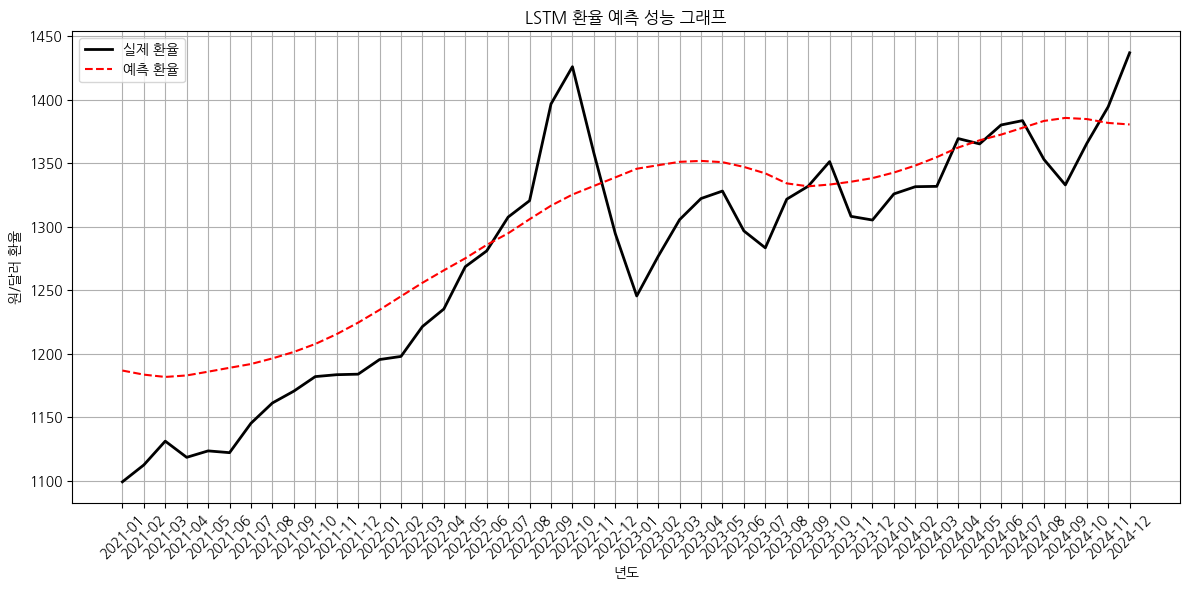

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

✅ Future 3-Month Forecasted Exchange Rates:
Month 1 (2025-01): 1379.8196 KRW/USD
Month 2 (2025-02): 1379.5753 KRW/USD
Month 3 (2025-03): 1378.2144 KRW/USD
Month 4 (2025-04): 1376.6702 KRW/USD
Month 5 (2025-05): 1377.2211 KRW/USD
Month 6 (2025-06): 1379.7686 KRW/USD
Month 7 (2025-07): 1382.1378 KRW/USD
Month 8 (2025-08): 1382.8679 KRW/USD
Month 9 (2025-09): 1384.0643 KRW/USD
Month 10 (2025-10): 1385.9124 KRW/USD
Month 11 (2025-11): 1388.1016 KRW/USD
Month 12 (2025-12): 1389.0015 KRW/USD
Month 13 (2026

<ipython-input-123-3956b8bb032f>:166: UserWarning:

This axis already has a converter set and is updating to a potentially incompatible converter



TypeError: tz must be string or tzinfo subclass, not <matplotlib.category.UnitData object at 0x78476df5e350>.

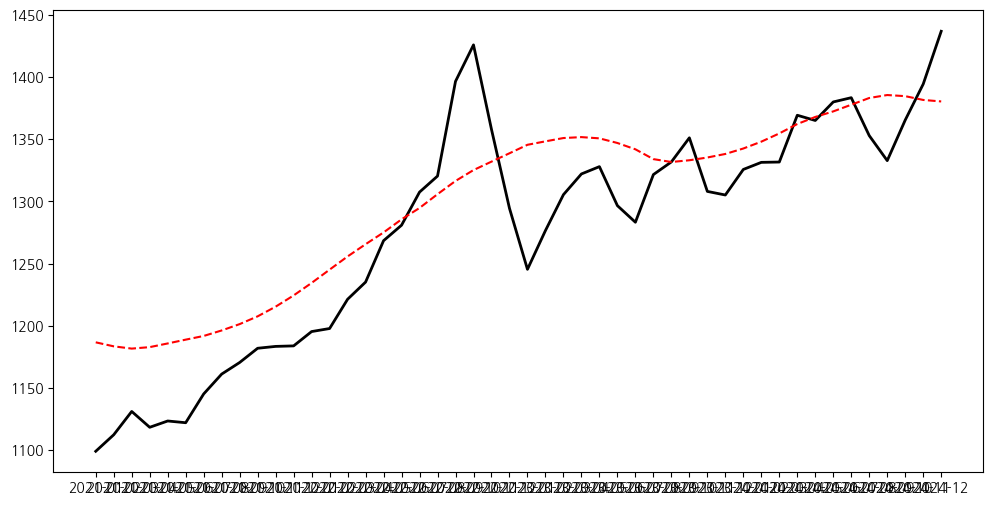

In [123]:
import os
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
from pandas.tseries.offsets import MonthBegin
import copy

# === 시드 고정 ===
def set_full_seed(seed=50):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

set_full_seed(50)

# === 데이터 준비 ===
features = ['경제 심리 지수', '한국 외환 보유액', 'vix', 'WTI 유가', '한국 실업률', '두바이 유가',
            'Brent 유가', '천연가스 가격', '유연탄 가격', '미국 주가지수',
            '한국 인플레이션율', '인플레이션 격차', '실질GDP성장률', 'M2',
            '금 가격', '구리 가격', '아연 가격', '알루미늄 가격', '니켈 가격',
            '외국인 투자 금액']
target = '원/달러환율'

X = df[features].ffill().bfill()
y = df[target].loc[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

def create_sequences(X, y, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled)

# === baseline 모델 ===
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(LSTM(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train_seq, y_train_seq, epochs=200, batch_size=16, validation_data=(X_test_seq, y_test_seq),
          callbacks=[early_stop], verbose=0)

y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test_seq)

baseline_rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))

# === Permutation Importance ===
importance_results = {}
for col_idx in range(X_test_scaled.shape[1]):
    X_test_perm = copy.deepcopy(X_test_seq)
    for i in range(X_test_perm.shape[0]):
        np.random.shuffle(X_test_perm[:, :, col_idx])

    y_pred_perm_scaled = model.predict(X_test_perm)
    y_pred_perm = scaler_y.inverse_transform(y_pred_perm_scaled)
    perm_rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_perm))
    importance = perm_rmse - baseline_rmse
    importance_results[col_idx] = importance

# 상위 10개 feature 선택
sorted_importance = sorted(importance_results.items(), key=lambda x: x[1], reverse=True)
top_10_indices = [idx for idx, _ in sorted_importance[:10]]
top_10_features = [features[idx] for idx in top_10_indices]

print("\n✅ Top 10 Important Features:")
for feat in top_10_features:
    print(f"- {feat}")

# === Top 10 feature로 모델 재학습 ===
X_train_top = X_train_scaled[:, top_10_indices]
X_test_top = X_test_scaled[:, top_10_indices]

X_train_seq_top, y_train_seq_top = create_sequences(X_train_top, y_train_scaled)
X_test_seq_top, y_test_seq_top = create_sequences(X_test_top, y_test_scaled)

model_top = Sequential()
model_top.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train_seq_top.shape[1], X_train_seq_top.shape[2])))
model_top.add(LSTM(32, activation='relu'))
model_top.add(Dense(1))
model_top.compile(optimizer='adam', loss='mse')

model_top.fit(X_train_seq_top, y_train_seq_top, epochs=200, batch_size=16,
              validation_data=(X_test_seq_top, y_test_seq_top),
              callbacks=[early_stop], verbose=0)

y_pred_top_scaled = model_top.predict(X_test_seq_top)
y_pred_top = scaler_y.inverse_transform(y_pred_top_scaled)
y_test_actual_top = scaler_y.inverse_transform(y_test_seq_top)

rmse = np.sqrt(mean_squared_error(y_test_actual_top, y_pred_top))
mae = mean_absolute_error(y_test_actual_top, y_pred_top)
r2 = r2_score(y_test_actual_top, y_pred_top)

print(f"\n✅ Final model Performance (Top 10 Features)")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

# === 성능 그래프 ===
test_dates_full = df.loc[X_test.index, 'TIME'].reset_index(drop=True)
test_dates = test_dates_full[12:]

plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_actual_top, label='실제 환율', color='black', linewidth=2)
plt.plot(test_dates, y_pred_top, label='예측 환율', linestyle='--', color='red')
plt.title('LSTM 환율 예측 성능 그래프')
plt.xlabel('년도')
plt.ylabel('원/달러 환율')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 미래 3개월 예측 ===
last_input_seq = X_test_top[-12:].reshape(1, 12, X_test_top.shape[1])
future_preds_scaled = []

for _ in range(13):
    future_pred_scaled = model_top.predict(last_input_seq)
    future_preds_scaled.append(future_pred_scaled[0])
    last_input_seq = np.append(last_input_seq[:, 1:, :], last_input_seq[:, -1:, :], axis=1)

future_preds = scaler_y.inverse_transform(np.array(future_preds_scaled))

# 미래 날짜 생성
last_date = pd.to_datetime(test_dates.iloc[-1])
future_dates = [last_date + MonthBegin(i) for i in range(1, 14)]
future_dates = pd.to_datetime(future_dates,format='%b-%y')

print("\n✅ Future 3-Month Forecasted Exchange Rates:")
for i, (date, pred) in enumerate(zip(future_dates, future_preds.flatten()), 1):
    print(f"Month {i} ({date.strftime('%Y-%m')}): {pred:.4f} KRW/USD")

# === 미래 예측 그래프 ===
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_actual_top, label='실제 환율', color='black', linewidth=2)
plt.plot(test_dates, y_pred_top, label='예측 환율', linestyle='--', color='red')
plt.plot(future_dates, future_preds, label='12개월 예측 환율', linestyle=':', color='blue', marker='o')
plt.title('LSTM 환율 예측')
plt.xlabel('년도')
plt.ylabel('원/달러 환율')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 미래 예측값 DataFrame 생성 ===
future_df = pd.DataFrame({
    'Month': [date.strftime('%Y-%m') for date in future_dates],
    'Predicted_Exchange_Rate': future_preds.flatten()
})

## 단기/중기 성능 확인

In [124]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 가정: 실제 환율값 (2025년 1월~5월) — 실제로는 사용자가 가진 데이터를 여기에 대입
actual_values_dict = {
    '2024-12': 1434.42,
    '2025-01': 1455.79,
    '2025-02': 1445.56,
    '2025-03': 1457.35,
    '2025-04': 1439.54,
    '2025-05': 1398.13
}
actual_df = pd.DataFrame({
    'Month': list(actual_values_dict.keys()),
    'Actual_Exchange_Rate': list(actual_values_dict.values())
})

# 예측값이 들어있는 future_df에서 2025년 1월~5월 값만 추출
merged_df = pd.merge(future_df, actual_df, on='Month')

# 단기 / 중기 구분
merged_df['구간'] = merged_df['Month'].apply(
    lambda x: '단기 (1~3월)' if x in ['2025-01', '2025-02', '2025-03'] else '중기 (4~5월)'
)

# 구간별 성능 계산
short = merged_df[merged_df['구간'] == '단기 (1~3월)']
mid = merged_df[merged_df['구간'] == '중기 (4~5월)']

results = pd.DataFrame([
    {
        '구간': '단기 (1~3월)',
        'RMSE': np.sqrt(mean_squared_error(short['Actual_Exchange_Rate'], short['Predicted_Exchange_Rate'])),
        'MAE': mean_absolute_error(short['Actual_Exchange_Rate'], short['Predicted_Exchange_Rate']),
        'R2 Score': r2_score(short['Actual_Exchange_Rate'], short['Predicted_Exchange_Rate'])
    },
    {
        '구간': '중기 (4~5월)',
        'RMSE': np.sqrt(mean_squared_error(mid['Actual_Exchange_Rate'], mid['Predicted_Exchange_Rate'])),
        'MAE': mean_absolute_error(mid['Actual_Exchange_Rate'], mid['Predicted_Exchange_Rate']),
        'R2 Score': r2_score(mid['Actual_Exchange_Rate'], mid['Predicted_Exchange_Rate'])
    }
])

print(results)


          구간       RMSE        MAE    R2 Score
0  단기 (1~3월)  73.909705  73.696916 -198.779268
1  중기 (4~5월)  46.849757  41.889382   -4.119932


# 내가 한 LSTM(과적합없애기)

In [125]:
import os
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import copy

# === 시드 고정 ===
def set_full_seed(seed=50):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

set_full_seed(50)

# === 데이터 준비 ===
features = ['경제 심리 지수', '한국 외환 보유액', 'vix', 'WTI 유가', '한국 실업률', '두바이 유가',
            'Brent 유가', '천연가스 가격', '유연탄 가격', '미국 주가지수',
            '한국 인플레이션율', '인플레이션 격차', '실질GDP성장률', 'M2',
            '금 가격', '구리 가격', '아연 가격', '알루미늄 가격', '니켈 가격',
            '외국인 투자 금액']
target = '원/달러환율'

X = df[features].ffill().bfill()
y = df[target].loc[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

def create_sequences(X, y, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled)

# === baseline 모델 ===
model2 = Sequential()
model2.add(LSTM(64, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model2.add(Dropout(0.3))
model2.add(LSTM(32))
model2.add(Dropout(0.3))
model2.add(Dense(1))
model2.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model2.fit(X_train_seq, y_train_seq, epochs=200, batch_size=16, validation_data=(X_test_seq, y_test_seq),
          callbacks=[early_stop], verbose=0)

y_pred_scaled = model2.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test_seq)
baseline_rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))

# === Permutation Importance ===
importance_results = {}
for col_idx in range(X_test_scaled.shape[1]):
    X_test_perm = copy.deepcopy(X_test_seq)
    for i in range(X_test_perm.shape[0]):
        np.random.shuffle(X_test_perm[:, :, col_idx])

    y_pred_perm_scaled = model2.predict(X_test_perm)
    y_pred_perm = scaler_y.inverse_transform(y_pred_perm_scaled)
    perm_rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_perm))
    importance = perm_rmse - baseline_rmse
    importance_results[col_idx] = importance

# 중요도 순위
sorted_importance = sorted(importance_results.items(), key=lambda x: x[1], reverse=True)
sorted_indices = [idx for idx, _ in sorted_importance]
sorted_features = [features[idx] for idx in sorted_indices]

print("\n✅ Feature Importance Ranking (Top to Bottom):")
for feat, idx in zip(sorted_features, sorted_indices):
    print(f"- {feat}: Importance = {importance_results[idx]:.4f}")

# === 실험: 상위 3, 5, 10, 15개 비교 ===
results = []

for top_n in [3, 5, 10, 15]:
    selected_indices = sorted_indices[:top_n]
    selected_feats = [features[i] for i in selected_indices]

    X_train_top = X_train_scaled[:, selected_indices]
    X_test_top = X_test_scaled[:, selected_indices]

    X_train_seq_top, y_train_seq_top = create_sequences(X_train_top, y_train_scaled)
    X_test_seq_top, y_test_seq_top = create_sequences(X_test_top, y_test_scaled)

    model2_top = Sequential()
    model2_top.add(LSTM(64, return_sequences=True, input_shape=(X_train_seq_top.shape[1], X_train_seq_top.shape[2])))
    model2_top.add(Dropout(0.3))
    model2_top.add(LSTM(32))
    model2_top.add(Dropout(0.3))
    model2_top.add(Dense(1))
    model2_top.compile(optimizer='adam', loss='mse')

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model2_top.fit(X_train_seq_top, y_train_seq_top, epochs=200, batch_size=16,
                  validation_data=(X_test_seq_top, y_test_seq_top),
                  callbacks=[early_stop], verbose=0)

    y_pred_top_scaled = model2_top.predict(X_test_seq_top)
    y_pred_top = scaler_y.inverse_transform(y_pred_top_scaled)
    y_test_actual_top = scaler_y.inverse_transform(y_test_seq_top)

    rmse = np.sqrt(mean_squared_error(y_test_actual_top, y_pred_top))
    mae = mean_absolute_error(y_test_actual_top, y_pred_top)
    r2 = r2_score(y_test_actual_top, y_pred_top)

    results.append({
        'Top_N_Features': top_n,
        'Selected_Features': selected_feats,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    })

# === 결과 출력 ===
print("\n✅ Final Results Comparison:")
for res in results:
    print(f"\n▶ Top {res['Top_N_Features']} Features")
    print(f"Selected: {res['Selected_Features']}")
    print(f"RMSE: {res['RMSE']:.4f}")
    print(f"MAE: {res['MAE']:.4f}")
    print(f"R²: {res['R2']:.4f}")

# === Top 10 feature로 모델 재학습 ===
top_10_indices = sorted_indices[:10]
X_train_top = X_train_scaled[:, top_10_indices]
X_test_top = X_test_scaled[:, top_10_indices]

X_train_seq_top, y_train_seq_top = create_sequences(X_train_top, y_train_scaled)
X_test_seq_top, y_test_seq_top = create_sequences(X_test_top, y_test_scaled)

model2_top = Sequential()
model2_top.add(LSTM(64, return_sequences=True, input_shape=(X_train_seq_top.shape[1], X_train_seq_top.shape[2])))
model2_top.add(Dropout(0.3))
model2_top.add(LSTM(32))
model2_top.add(Dropout(0.3))
model2_top.add(Dense(1))
model2_top.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model2_top.fit(
    X_train_seq_top, y_train_seq_top, epochs=200, batch_size=16,
              validation_data=(X_test_seq_top, y_test_seq_top),
              callbacks=[early_stop], verbose=0)

y_pred_top_scaled = model2_top.predict(X_test_seq_top)
y_pred_top = scaler_y.inverse_transform(y_pred_top_scaled)
y_test_actual_top = scaler_y.inverse_transform(y_test_seq_top)

rmse = np.sqrt(mean_squared_error(y_test_actual_top, y_pred_top))
mae = mean_absolute_error(y_test_actual_top, y_pred_top)
r2 = r2_score(y_test_actual_top, y_pred_top)

print(f"\n✅ Final Model2 Performance (Top 10 Features)")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

✅ Feature Importance Ranking (Top to Bottom):
- 유연탄 가격: Importance = 22.1669
- 한국 인플레이션율: Importance = 18.5679
- 미국 주가지수: Importance = 7.1429
- 경제 심리 지수: Importance = 4.2563
- 아연 가격: Importance = 3.34

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 451ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step

✅ Final Results Comparison:

▶ Top 3 Features
Selected: ['유연탄 가격', '한국 인플레이션율', '미국 주가지수']
RMSE: 91.3010
MAE: 75.7663
R²: 0.0171

▶ Top 5 Features
Selected: ['유연탄 가격', '한국 인플레이션율', '미국 주가지수', '경제 심리 지수', '아연 가격']
RMSE: 47.8573
MAE: 39.3900
R²: 0.7299

▶ Top 10 Features
Selected: ['유연탄 가격', '한국 인플레이션율', '미국 주가지수', '경제 심리 지수', '아연 가격', '천연가스 가격', 'M2', '실질GDP성장률', '금 가격', '인플레이션 격차']
RMSE: 42.7931
MAE: 31.2708
R²: 0.7841

▶ Top 15 Features
Selected: ['유연탄 가격', '한국 인플레이션율', '미국 주가지수', '경제 심리 지수', '아연 가격', '천연가스 가격', 'M2', '실질GDP성장률', '금 가격', '인플레이션 격차', '두바이 유가', '외국인 투자 금액', '한국 외환 보유액', '알루미늄 가격', '니켈 가격']
RMSE: 75.3515
MAE: 55.3000
R²: 0.3305


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step

✅ Final Model2 Performance (Top 10 Features)
RMSE: 51.8807
MAE: 43.2326
R²: 0.6826


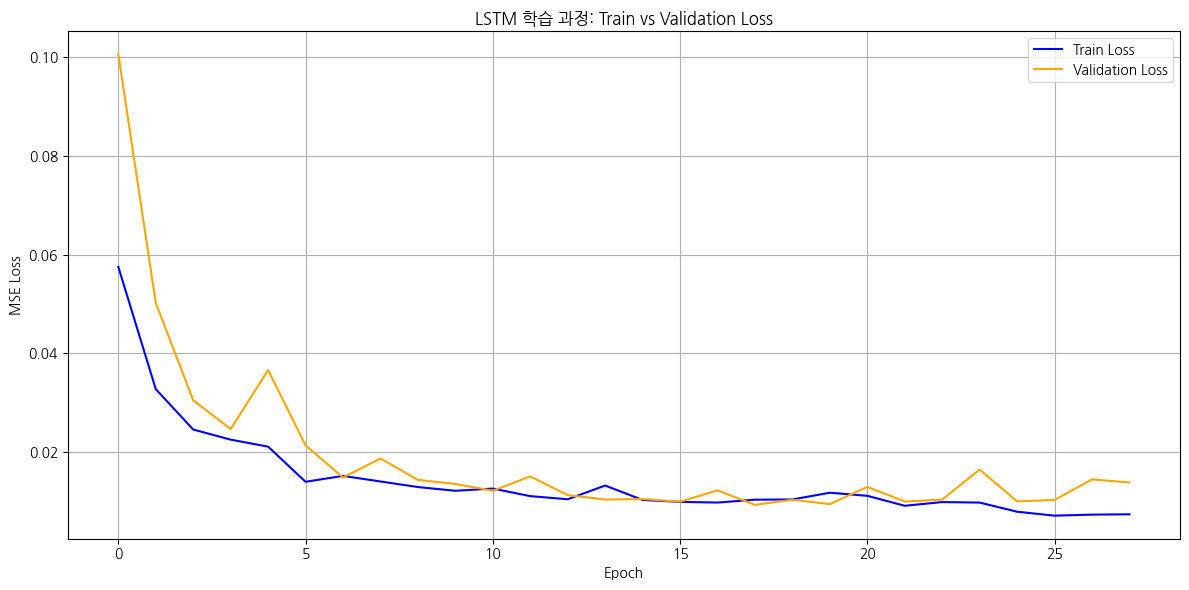

In [126]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('LSTM 학습 과정: Train vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


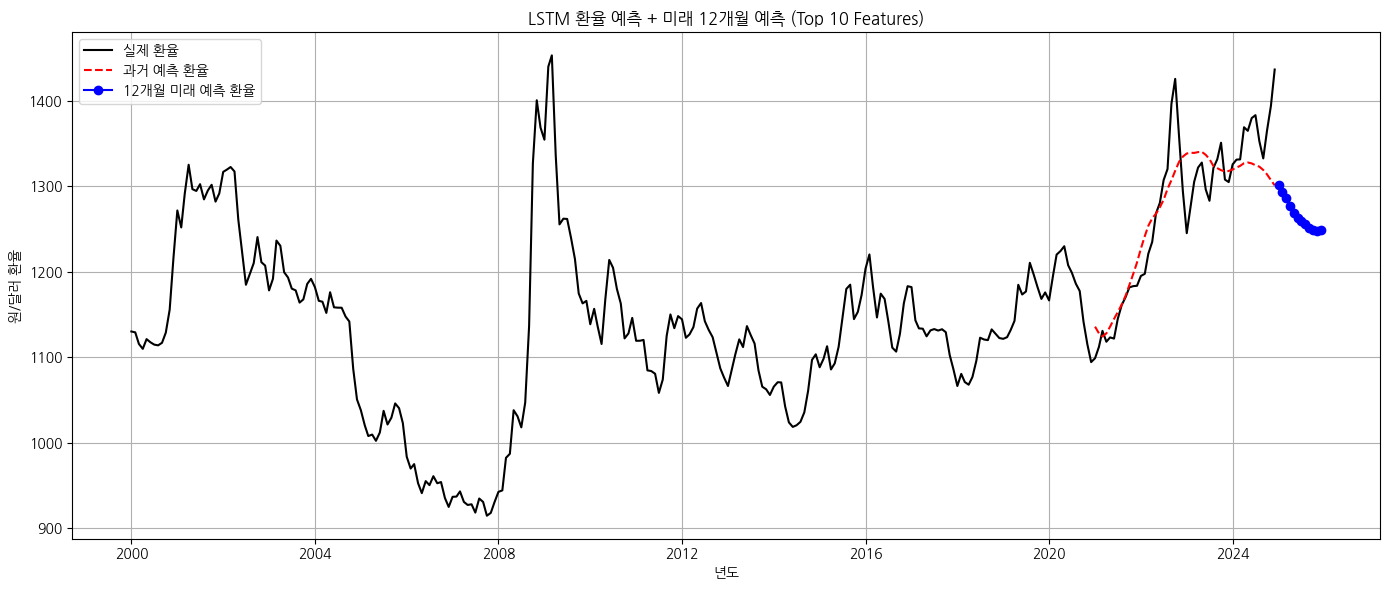

In [127]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import copy

# === 시드 고정 ===
def set_full_seed(seed=50):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

set_full_seed(50)

# === 날짜 인덱스로 지정 ===
df["TIME"] = pd.to_datetime(df["TIME"])  # 필요 시
df.set_index("TIME", inplace=True)

# === 데이터 준비 ===
features = ['경제 심리 지수', '한국 외환 보유액', 'vix', 'WTI 유가', '한국 실업률', '두바이 유가',
            'Brent 유가', '천연가스 가격', '유연탄 가격', '미국 주가지수',
            '한국 인플레이션율', '인플레이션 격차', '실질GDP성장률', 'M2',
            '금 가격', '구리 가격', '아연 가격', '알루미늄 가격', '니켈 가격',
            '외국인 투자 금액']
target = '원/달러환율'

X = df[features].ffill().bfill()
y = df[target].loc[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

def create_sequences(X, y, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled)

# === 모델 학습 ===
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(32))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train_seq, y_train_seq, epochs=200, batch_size=16, validation_data=(X_test_seq, y_test_seq),
          callbacks=[early_stop], verbose=0)

# === Permutation Importance 기반 상위 10개 변수 선택 ===
baseline_rmse = np.sqrt(mean_squared_error(scaler_y.inverse_transform(y_test_seq),
                                            scaler_y.inverse_transform(model.predict(X_test_seq))))
importance_results = {}
for col_idx in range(X_test_scaled.shape[1]):
    X_test_perm = copy.deepcopy(X_test_seq)
    for i in range(X_test_perm.shape[0]):
        np.random.shuffle(X_test_perm[:, :, col_idx])
    y_pred_perm = model.predict(X_test_perm)
    rmse = np.sqrt(mean_squared_error(scaler_y.inverse_transform(y_test_seq),
                                      scaler_y.inverse_transform(y_pred_perm)))
    importance_results[col_idx] = rmse - baseline_rmse

sorted_indices = sorted(importance_results, key=importance_results.get, reverse=True)
top_10_indices = sorted_indices[:10]

# === Top 10 변수로 모델 재학습 ===
X_train_top = X_train_scaled[:, top_10_indices]
X_test_top = X_test_scaled[:, top_10_indices]
X_train_seq_top, y_train_seq_top = create_sequences(X_train_top, y_train_scaled)
X_test_seq_top, y_test_seq_top = create_sequences(X_test_top, y_test_scaled)

model_top = Sequential()
model_top.add(LSTM(64, return_sequences=True, input_shape=(X_train_seq_top.shape[1], X_train_seq_top.shape[2])))
model_top.add(Dropout(0.3))
model_top.add(LSTM(32))
model_top.add(Dropout(0.3))
model_top.add(Dense(1))
model_top.compile(optimizer='adam', loss='mse')

history = model_top.fit(X_train_seq_top, y_train_seq_top, epochs=200, batch_size=16,
                        validation_data=(X_test_seq_top, y_test_seq_top),
                        callbacks=[early_stop], verbose=0)

# === 과거 예측 결과
y_pred_top_scaled = model_top.predict(X_test_seq_top)
y_pred_top = scaler_y.inverse_transform(y_pred_top_scaled)
y_test_actual_top = scaler_y.inverse_transform(y_test_seq_top)

# === 미래 12개월 예측 (Recursive)
last_sequence = X_test_seq_top[-1]
future_preds_scaled = []

for _ in range(12):
    pred_scaled = model_top.predict(last_sequence[np.newaxis, :, :], verbose=0)
    future_preds_scaled.append(pred_scaled[0])
    new_input = np.vstack([last_sequence[1:], last_sequence[-1]])  # 구조만 유지
    last_sequence = new_input

future_preds = scaler_y.inverse_transform(np.array(future_preds_scaled)).flatten()

# === 시각화
past_pred_dates = df.index[-len(y_pred_top):]
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=12, freq='MS')

plt.figure(figsize=(14, 6))
plt.plot(df.index, df[target], label='실제 환율', color='black')
plt.plot(past_pred_dates, y_pred_top, linestyle='--', label='과거 예측 환율', color='red')
plt.plot(future_dates, future_preds, 'o-', label='12개월 미래 예측 환율', color='blue')
plt.title("LSTM 환율 예측 + 미래 12개월 예측 (Top 10 Features)")
plt.xlabel("년도")
plt.ylabel("원/달러 환율")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 추가 프로젝트-원자재가격 예측을 통한 수입단가 계산 시뮬레이션

## 원자재 가격 예측(Prophet)-철광석

In [128]:
df = pd.read_csv('/content/drive/MyDrive/LIKELION_데이터분석/datathon/final.csv')

In [129]:
%%capture
!pip install prophet

In [130]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     300 non-null    int64  
 1   TIME           300 non-null    object 
 2   원/달러환율         300 non-null    float64
 3   한국 장기 시장 금리    291 non-null    float64
 4   미국 장기 시장 금리    300 non-null    float64
 5   중국 장기 시장 금리    132 non-null    float64
 6   한국 단기 시장 금리    300 non-null    float64
 7   미국 단기 시장 금리    299 non-null    float64
 8   중국 단기 시장 금리    299 non-null    float64
 9   전체 수출 총액       300 non-null    int64  
 10  미국 수출 총액       300 non-null    int64  
 11  중국 수출 총액       300 non-null    int64  
 12  전체 수입 총액       300 non-null    int64  
 13  미국 수입 총액       300 non-null    int64  
 14  중국 수입 총액       300 non-null    int64  
 15  소득 교역 조건 지수    300 non-null    float64
 16  해외 직접 투자 금액    300 non-null    int64  
 17  경제 심리 지수       264 non-null    float64
 18  한국 기준 금리  

In [132]:
import pandas as pd

# 데이터 불러오기
df['TIME'] = pd.to_datetime(df['TIME'])

# Prophet에 맞는 포맷으로 변경: 'ds' = 날짜, 'y' = 예측 대상
df_prophet = df[['TIME', '철광석 가격']].rename(columns={
    'TIME': 'ds',
    '철광석 가격': 'y'
})

# 🔽 2000년 이후로 필터링
df_prophet = df_prophet[df_prophet['ds'] >= '2000-01-01']

# 결측치 보간 (중요!)
df_prophet['y'] = df_prophet['y'].fillna(method='ffill').fillna(method='bfill')


<ipython-input-132-f5815ec3030d>:16: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [133]:
model = Prophet()
model.fit(df_prophet)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc0bo_9e6/fggsqa2v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc0bo_9e6/r5nr4u7k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93162', 'data', 'file=/tmp/tmpc0bo_9e6/fggsqa2v.json', 'init=/tmp/tmpc0bo_9e6/r5nr4u7k.json', 'output', 'file=/tmp/tmpc0bo_9e6/prophet_modelkykmbten/prophet_model-20250512081755.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:17:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:17:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


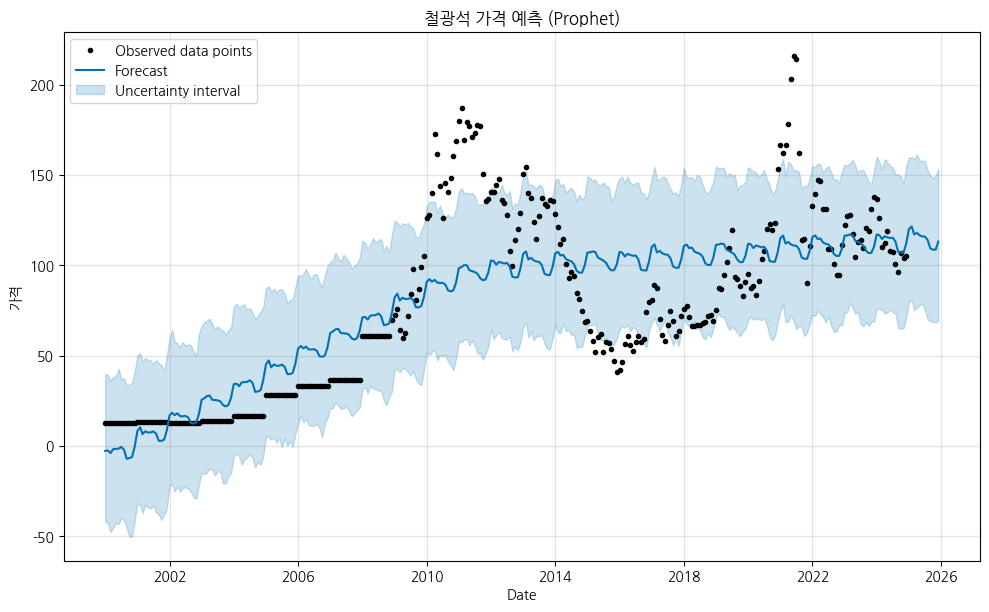

In [134]:
# 예: 12개월 이후까지 예측
future = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(future)

model.plot(forecast)
plt.title('철광석 가격 예측 (Prophet)')
plt.xlabel('Date')
plt.ylabel('가격')
plt.grid(True)
plt.legend()
plt.show()


- 검정 점: 실제
- 파란 선: 예측
- 파란 영역: 신뢰구간(95%)

In [135]:
# 1. forecast + 실제값 df_prophet merge
forecast_eval = pd.merge(
    forecast[['ds', 'yhat']],
    df_prophet[['ds', 'y']],
    on='ds',
    how='left'
)

# 2. 실제값 있는 구간만 남기기
#eval_df = forecast_eval.dropna(subset=['y'])
eval_df = forecast_eval

# 3. 최근 12개월 기준으로 tail
recent_12_months = eval_df.tail(24)
recent_12_months.reset_index(drop=True, inplace=True)

# 4. 결과 출력
print(recent_12_months)


           ds        yhat       y
0  2024-01-01  117.056777  136.59
1  2024-02-01  116.635842  125.93
2  2024-03-01  114.553545  110.19
3  2024-04-01  116.040221  112.23
4  2024-05-01  115.504677  119.24
5  2024-06-01  114.996160  108.10
6  2024-07-01  115.255107  107.39
7  2024-08-01  113.107674  100.91
8  2024-09-01  107.412898   96.24
9  2024-10-01  107.058567  106.61
10 2024-11-01  107.031764  103.98
11 2024-12-01  112.027935  105.34
12 2025-01-01  120.104942     NaN
13 2025-02-01  121.504489     NaN
14 2025-03-01  117.059366     NaN
15 2025-04-01  117.985364     NaN
16 2025-05-01  116.616908     NaN
17 2025-06-01  115.986513     NaN
18 2025-07-01  115.889614     NaN
19 2025-08-01  114.030407     NaN
20 2025-09-01  109.324734     NaN
21 2025-10-01  108.647633     NaN
22 2025-11-01  108.677030     NaN
23 2025-12-01  113.145135     NaN


In [136]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1. 실제값과 예측값 merge
forecast_eval = pd.merge(
    forecast[['ds', 'yhat']],
    df_prophet[['ds', 'y']],
    on='ds',
    how='left'
)

# 2. 2000년 이후로 필터링
forecast_eval = forecast_eval[forecast_eval['ds'] >= '2000-01-01']

# 3. 실제값 있는 구간만 비교
eval_df = forecast_eval.dropna(subset=['y'])

# 4. 성능 지표 계산
y_true = eval_df['y']
y_pred = eval_df['yhat']

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"📊 Prophet 철광석 가격 예측 성능:")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²  : {r2:.4f}")


📊 Prophet 철광석 가격 예측 성능:
MAE : 24.87
RMSE: 32.12
R²  : 0.5955


## 논문 내용 기반

In [137]:
import pandas as pd

# 파일 경로
crb_path = '/content/drive/MyDrive/LIKELION_데이터분석/datathon/CRB.csv'

crb_df = pd.read_csv(crb_path)

# 열 이름 확인
print(crb_df.columns)

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')


In [138]:
# 날짜 형식 통일
crb_df['Date'] = pd.to_datetime(crb_df['Date'])
crb_df = crb_df.rename(columns={'Date': 'TIME', 'Price': 'crb_price'})
crb_df = crb_df[['TIME', 'crb_price']].sort_values('TIME')

# 2. 기존 df도 datetime으로 맞춤
df['TIME'] = pd.to_datetime(df['TIME'])

# 3. 병합
df = pd.merge(df, crb_df, on='TIME', how='left')

# 4. 확인
print(df[['TIME', 'crb_price']].head())

        TIME  crb_price
0 2000-01-01     125.78
1 2000-02-01     129.98
2 2000-03-01     130.84
3 2000-04-01     129.71
4 2000-05-01     141.10


In [139]:
df['crb_price'].isnull().sum()

np.int64(0)

In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 77 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Unnamed: 0     300 non-null    int64         
 1   TIME           300 non-null    datetime64[ns]
 2   원/달러환율         300 non-null    float64       
 3   한국 장기 시장 금리    291 non-null    float64       
 4   미국 장기 시장 금리    300 non-null    float64       
 5   중국 장기 시장 금리    132 non-null    float64       
 6   한국 단기 시장 금리    300 non-null    float64       
 7   미국 단기 시장 금리    299 non-null    float64       
 8   중국 단기 시장 금리    299 non-null    float64       
 9   전체 수출 총액       300 non-null    int64         
 10  미국 수출 총액       300 non-null    int64         
 11  중국 수출 총액       300 non-null    int64         
 12  전체 수입 총액       300 non-null    int64         
 13  미국 수입 총액       300 non-null    int64         
 14  중국 수입 총액       300 non-null    int64         
 15  소득 교역 조건 지수    300 non-

In [141]:
from statsmodels.tsa.stattools import adfuller

# 1. 타겟 변수 생성 (3개월 뒤 철광석 가격)
df['철광석_타겟'] = df['철광석 가격'].shift(-3)

# 2. 다변량 후보 변수 리스트
candidate_vars = [
    '니켈 가격',
    '두바이 유가',
    'Brent 유가',
    'WTI 유가',
    '원/달러환율',
    '금 가격',
    '한국 소비자 물가지수',
    'crb_price'
]

# 3. ADF Test + 차분 자동화 함수 정의
def adf_test_and_diff(df, var_list):
    result_dict = {}
    for var in var_list:
        series = df[var].dropna()
        adf_result = adfuller(series)
        p_val = adf_result[1]
        diff_count = 0

        # 차분이 필요하면 반복
        while p_val >= 0.05 and diff_count < 3:
            series = series.diff().dropna()
            adf_result = adfuller(series)
            p_val = adf_result[1]
            diff_count += 1

        result_dict[var] = {
            'adf_stat': adf_result[0],
            'p_value': p_val,
            'diff_count': diff_count
        }

    return pd.DataFrame(result_dict).T

# 4. 실행
adf_results = adf_test_and_diff(df, candidate_vars)
adf_results


,adf_stat,p_value,diff_count
니켈 가격,-10.264452,4.154336e-18,1.0
두바이 유가,-9.451089,4.614352e-16,1.0
Brent 유가,-11.906170,5.429802e-22,1.0
WTI 유가,-2.979097,3.689308e-02,0.0
원/달러환율,-12.372880,5.233364e-23,1.0
금 가격,-13.632044,1.715966e-25,1.0
한국 소비자 물가지수,-3.030882,3.210936e-02,1.0
crb_price,-9.835672,4.903028e-17,1.0


🔎 ADF 테스트 + 차분 과정이 필요한 이유: 시계열의 정상성 확보

정상성이란?

: 시계열 데이터가 시간이 지나도 평균, 분산, 공분산이 일정한 상태

- ADF테스트 → 정상성 여부 판단(p-value < 0.05면 정상)

- 차분(differencing) → 비정상 시계열을 정상으로 바꾸기 위한 수학적 변환

    - diff_count가 1 이상인 경우 = 비정상시계열이지만 1차 차분으로 정상 변환할 수 있는 변수


In [142]:
diff_counts = {k: int(v) for k, v in adf_results['diff_count'].to_dict().items()}

# 차분된 컬럼 생성
for var, d in diff_counts.items():
    if d == 0:
        df[f'{var}_diff'] = df[var]  # 그대로 사용
    else:
        temp = df[var].copy()
        for i in range(d):
            temp = temp.diff()
        df[f'{var}_diff'] = temp

# 생성된 diff 컬럼들 확인
diff_columns = [f"{var}_diff" for var in diff_counts.keys()]
df[diff_columns + ['TIME']].head()


,니켈 가격_diff,두바이 유가_diff,Brent 유가_diff,WTI 유가_diff,원/달러환율_diff,금 가격_diff,한국 소비자 물가지수_diff,crb_price_diff,TIME
0,NaN,NaN,NaN,27.22,NaN,NaN,NaN,NaN,2000-01-01
1,1268.50,1.36,2.40,29.36,-1.03,15.65,0.22,4.20,2000-02-01
2,671.65,0.38,-0.54,29.89,-13.54,-12.80,0.37,0.86,2000-03-01
3,-508.90,-2.75,-4.34,25.80,-5.74,-7.27,-0.30,-1.13,2000-04-01
4,376.41,3.28,4.66,28.83,11.36,-2.91,-0.36,11.39,2000-05-01


In [143]:
# ADF test 결과를 표 형식으로 보기 좋게 정리
# 기존에 저장된 결과 (adf_results)를 사용

# ADF 및 P-value (차분 전) 저장
from statsmodels.tsa.stattools import adfuller

adf_table = []

for var in candidate_vars:
    original = df[var].dropna()
    diff = df[f"{var}_diff"].dropna()

    adf_before = adfuller(original)
    adf_after = adfuller(diff)

    adf_table.append({
        '변수명': var,
        '차분 횟수': diff_counts[var],
        '차분 전 ADF': round(adf_before[0], 4),
        '차분 전 P-Value': round(adf_before[1], 5),
        '차분 후 ADF': round(adf_after[0], 4),
        '차분 후 P-Value': round(adf_after[1], 5),
    })

adf_df_pretty = pd.DataFrame(adf_table)
display(adf_df_pretty)


,변수명,차분 횟수,차분 전 ADF,차분 전 P-Value,차분 후 ADF,차분 후 P-Value
0,니켈 가격,1,-2.5610,0.10132,-10.2645,0.00000
1,두바이 유가,1,-2.7578,0.06455,-9.4511,0.00000
2,Brent 유가,1,-2.6964,0.07467,-11.9062,0.00000
3,WTI 유가,0,-2.9791,0.03689,-2.9791,0.03689
4,원/달러환율,1,-1.7199,0.42087,-12.3729,0.00000
5,금 가격,1,0.7347,0.99051,-13.6320,0.00000
6,한국 소비자 물가지수,1,-0.1243,0.94697,-3.0309,0.03211
7,crb_price,1,-2.1570,0.22222,-9.8357,0.00000


ADF테스틑 t-통게량 계열로
통계량 자체가 작을수록 (음수로 갈수록) 정상성에 더 강하다라는 뜻

In [144]:
from itertools import combinations
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# 타겟 변수
target = '철광석_타겟'

# 차분된 변수 리스트
feature_vars = [
    '니켈 가격_diff', '두바이 유가_diff', 'Brent 유가_diff', 'WTI 유가_diff',
    '원/달러환율_diff', '금 가격_diff', '한국 소비자 물가지수_diff', 'crb_price_diff'
]

# 조합 생성
all_combos = []
for r in range(2, len(feature_vars) + 1):
    all_combos += list(combinations(feature_vars, r))

# 결과 저장
results = []

# 실행 루프
for combo in all_combos:
    # 데이터 구성
    subset = list(combo) + [target]
    df_subset = df[subset].dropna()

    # train-test split
    X = df_subset.drop(columns=[target])
    y = df_subset[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # 모델 학습
    model = XGBRegressor(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # 평가 지표
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    results.append({
        "조합": combo,
        "MAE": mae,
        "MAPE": mape
    })

# 결과 정리
results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by='MAPE')

# 상위 3개 조합
top_3 = results_df_sorted.head(3)
# 하위 3개 조합
bottom_3 = results_df_sorted.tail(3)

# 결과 출력
print("✅ [상위 3개 조합]")
print(top_3)
print("\n❌ [하위 3개 조합]")
print(bottom_3)


✅ [상위 3개 조합]
                                                    조합        MAE       MAPE
198  (두바이 유가_diff, Brent 유가_diff, 금 가격_diff, 한국 소비자...  37.926978  29.196163
126  (두바이 유가_diff, Brent 유가_diff, 금 가격_diff, 한국 소비자...  38.913401  29.297715
138  (두바이 유가_diff, 금 가격_diff, 한국 소비자 물가지수_diff, crb...  39.196273  30.464372

❌ [하위 3개 조합]
                                조합        MAE       MAPE
24   (원/달러환율_diff, crb_price_diff)  60.576425  46.587083
6     (니켈 가격_diff, crb_price_diff)  61.870682  47.941025
5   (니켈 가격_diff, 한국 소비자 물가지수_diff)  61.976096  48.678614


In [145]:
from sklearn.model_selection import GridSearchCV

# 상위 1개 조합 사용
best_combo = [
    '두바이 유가_diff', 'Brent 유가_diff', '금 가격_diff', '한국 소비자 물가지수_diff'
]

# 학습 데이터 구성
df_best = df[best_combo + ['철광석_타겟']].dropna()
X_best = df_best[best_combo]
y_best = df_best['철광석_타겟']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X_best, y_best, test_size=0.2, shuffle=False)

# 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [2, 4, 6],
    'learning_rate': [0.01, 0.1, 0.3]
}

# 모델 정의 및 GridSearch
xgb_model = XGBRegressor(random_state=42)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring='neg_mean_absolute_error', cv=3, verbose=0)

grid_search.fit(X_train, y_train)

# 최적 파라미터 및 성능 확인
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# 성능 평가
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = r2_score(y_test, y_pred)

{
    "Best Parameters": best_params,
    "MAE": mae,
    "MAPE": mape,
    "R²": r2
}

{'Best Parameters': {'learning_rate': 0.01,
  'max_depth': 2,
  'n_estimators': 100},
 'MAE': 49.1914598795573,
 'MAPE': np.float64(37.10444976163405),
 'R²': -3.0075379224943095}

In [146]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# 데이터 준비
best_vars = ['두바이 유가_diff', 'Brent 유가_diff', '금 가격_diff', '한국 소비자 물가지수_diff']
df_best = df[best_vars + ['철광석_타겟']].dropna()
X = df_best[best_vars]
y = df_best['철광석_타겟']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 실험할 파라미터 조합들
param_sets = [
    {"n_estimators": 300, "max_depth": 4, "learning_rate": 0.1},
    {"n_estimators": 500, "max_depth": 5, "learning_rate": 0.05},
    {"n_estimators": 300, "max_depth": 6, "learning_rate": 0.07}
]

# 결과 저장
for i, params in enumerate(param_sets, 1):
    model = XGBRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    r2 = r2_score(y_test, y_pred)

    print(f"⚙️ [세트 {i}] params: {params}")
    print(f"   ▶ MAE: {mae:.2f}, MAPE: {mape:.2f}, R²: {r2:.4f}\n")

⚙️ [세트 1] params: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.1}
   ▶ MAE: 44.26, MAPE: 34.14, R²: -2.6005

⚙️ [세트 2] params: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.05}
   ▶ MAE: 41.71, MAPE: 32.16, R²: -2.2822

⚙️ [세트 3] params: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.07}
   ▶ MAE: 38.84, MAPE: 29.33, R²: -2.0718



In [147]:
param_sets = [
    {"n_estimators": 400, "max_depth": 6, "learning_rate": 0.07},  # 세트 3 기반 강화
    {"n_estimators": 500, "max_depth": 5, "learning_rate": 0.07},  # depth 줄이고 estimator 확대
    {"n_estimators": 600, "max_depth": 4, "learning_rate": 0.09},  # depth 낮추고 빠르게 학습
]

for i, params in enumerate(param_sets, 1):
    model = XGBRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    r2 = r2_score(y_test, y_pred)

    print(f"⚙️ [최적화 세트 {i}] params: {params}")
    print(f"   ▶ MAE: {mae:.2f}, MAPE: {mape:.2f}, R²: {r2:.4f}\n")



⚙️ [최적화 세트 1] params: {'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.07}
   ▶ MAE: 38.91, MAPE: 29.39, R²: -2.0765

⚙️ [최적화 세트 2] params: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.07}
   ▶ MAE: 40.43, MAPE: 31.18, R²: -2.1834

⚙️ [최적화 세트 3] params: {'n_estimators': 600, 'max_depth': 4, 'learning_rate': 0.09}
   ▶ MAE: 43.12, MAPE: 33.43, R²: -2.5259



## ARIMA(단변량)

In [148]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. 시계열 준비
ts = df[['TIME', '철광석 가격']].copy()
ts = ts.dropna()
ts.set_index('TIME', inplace=True)

# 2. 1차 차분
ts['diff'] = ts['철광석 가격'].diff()
ts = ts.dropna()

# 3. ARIMA (p,1,q) 자동 탐색
best_score = float('inf')
best_order = None

for p in range(0, 4):
    for q in range(0, 4):
        try:
            model = ARIMA(ts['diff'], order=(p, 1, q))
            model_fit = model.fit()
            aic = model_fit.aic
            if aic < best_score:
                best_score = aic
                best_order = (p, 1, q)
        except:
            continue

print(f"📌 Best ARIMA Order: {best_order} (AIC: {best_score:.2f})")

# 4. 전체 재학습 및 예측
model = ARIMA(ts['철광석 가격'], order=best_order)
model_fit = model.fit()

# 5. test셋 정의 (3개월 예측)
n_test = 3
y_pred = model_fit.forecast(steps=n_test)
y_true = df['철광석 가격'].shift(-n_test).dropna().iloc[-n_test:]

# 6. 성능 지표 계산
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("\n📊 [ARIMA 성능 평가]")
print(f"▶ MAE   : {mae:.2f}")
print(f"▶ RMSE  : {rmse:.2f}")
print(f"▶ R²     : {r2:.4f}")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so

📌 Best ARIMA Order: (3, 1, 3) (AIC: 2140.01)

📊 [ARIMA 성능 평가]
▶ MAE   : 1.10
▶ RMSE  : 1.49
▶ R²     : -0.9324


## LSTM

In [149]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 1. 사용 변수
features = ['니켈 가격', '두바이 유가', 'Brent 유가', 'WTI 유가', '원/달러환율', '금 가격', '한국 소비자 물가지수', 'crb_price']
target = '철광석 가격'

# 2. 결측치 제거 후 정규화
df = df.dropna(subset=features + [target]).copy()
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[features + [target]]), columns=features + [target])
df_scaled['TIME'] = df['TIME'].values  # 시계열 정보 유지

# 3. 시퀀스 생성 함수
def create_sequences(data, feature_cols, target_col, input_len=12, pred_gap=3):
    X, y = [], []
    for i in range(len(data) - input_len - pred_gap + 1):
        X.append(data[feature_cols].iloc[i : i+input_len].values)
        y.append(data[target_col].iloc[i+input_len+pred_gap-1])
    return np.array(X), np.array(y)

X, y = create_sequences(df_scaled, features, target, input_len=12, pred_gap=3)

# 4. train/test 분리
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print("✅ 시퀀스 생성 완료:", X_train.shape, y_train.shape)


✅ 시퀀스 생성 완료: (228, 12, 8) (228,)


In [150]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# 1. 모델 정의
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 2. 학습
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# 3. 예측
y_pred = model.predict(X_test)

# 4. 평가 지표
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / np.where(y_test == 0, 1e-5, y_test))) * 100
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"📊 [LSTM 성능 평가]")
print(f"▶ MAE  : {mae:.2f}")
print(f"▶ MAPE : {mape:.2f}")
print(f"▶ RMSE : {rmse:.2f}")
print(f"▶ R²    : {r2:.4f}")


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.1023 - val_loss: 0.0107
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0326 - val_loss: 0.0053
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0266 - val_loss: 0.0038
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0241 - val_loss: 0.0049
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0197 - val_loss: 0.0039
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0177 - val_loss: 0.0038
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0152 - val_loss: 0.0045
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0123 - val_loss: 0.0089
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0107 - val_loss: 0.0209
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0093 - val_loss: 0.0253
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076 - val_loss: 0.0259
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0060 - v

# 수입 단가 계산 시뮬레이션
예측된 환율(LSTM) × 예측된 철광석 가격(Prophet) → 다음달 수입단가(원화)
- prophet 사용이유: 성능 + 설명력까지 좋은 모델
- 수입단가 시계열로 정리해서 변화율 추이 또는 리스크 판단 기준 도출

In [151]:
import os
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from pandas.tseries.offsets import MonthEnd
import copy

# === 시드 고정 ===
def set_full_seed(seed=50):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

set_full_seed(50)

# === 데이터 준비 ===
features = ['경제 심리 지수', '한국 외환 보유액', 'vix', 'WTI 유가', '한국 실업률', '두바이 유가',
            'Brent 유가', '천연가스 가격', '유연탄 가격', '미국 주가지수',
            '한국 인플레이션율', '인플레이션 격차', '실질GDP성장률', 'M2',
            '금 가격', '구리 가격', '아연 가격', '알루미늄 가격', '니켈 가격',
            '외국인 투자 금액']
target = '원/달러환율'

X = df[features].ffill().bfill()
y = df[target].loc[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

def create_sequences(X, y, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled)

# === baseline 모델 ===
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(LSTM(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train_seq, y_train_seq, epochs=200, batch_size=16, validation_data=(X_test_seq, y_test_seq),
          callbacks=[early_stop], verbose=0)

y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test_seq)
baseline_rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))

# === Permutation Importance ===
importance_results = {}
for col_idx in range(X_test_scaled.shape[1]):
    X_test_perm = copy.deepcopy(X_test_seq)
    for i in range(X_test_perm.shape[0]):
        np.random.shuffle(X_test_perm[:, :, col_idx])

    y_pred_perm_scaled = model.predict(X_test_perm)
    y_pred_perm = scaler_y.inverse_transform(y_pred_perm_scaled)
    perm_rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_perm))
    importance = perm_rmse - baseline_rmse
    importance_results[col_idx] = importance

# 중요도 순위
sorted_importance = sorted(importance_results.items(), key=lambda x: x[1], reverse=True)
sorted_indices = [idx for idx, _ in sorted_importance]
sorted_features = [features[idx] for idx in sorted_indices]

print("\n✅ Feature Importance Ranking (Top to Bottom):")
for feat, idx in zip(sorted_features, sorted_indices):
    print(f"- {feat}: Importance = {importance_results[idx]:.4f}")

# === 실험: 상위 3, 5, 10, 15개 비교 ===
results = []

for top_n in [3, 5, 10, 15]:
    selected_indices = sorted_indices[:top_n]
    selected_feats = [features[i] for i in selected_indices]

    X_train_top = X_train_scaled[:, selected_indices]
    X_test_top = X_test_scaled[:, selected_indices]

    X_train_seq_top, y_train_seq_top = create_sequences(X_train_top, y_train_scaled)
    X_test_seq_top, y_test_seq_top = create_sequences(X_test_top, y_test_scaled)

    model_top = Sequential()
    model_top.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train_seq_top.shape[1], X_train_seq_top.shape[2])))
    model_top.add(LSTM(32, activation='relu'))
    model_top.add(Dense(1))
    model_top.compile(optimizer='adam', loss='mse')

    model_top.fit(X_train_seq_top, y_train_seq_top, epochs=200, batch_size=16,
                  validation_data=(X_test_seq_top, y_test_seq_top),
                  callbacks=[early_stop], verbose=0)

    y_pred_top_scaled = model_top.predict(X_test_seq_top)
    y_pred_top = scaler_y.inverse_transform(y_pred_top_scaled)
    y_test_actual_top = scaler_y.inverse_transform(y_test_seq_top)

    rmse = np.sqrt(mean_squared_error(y_test_actual_top, y_pred_top))
    mae = mean_absolute_error(y_test_actual_top, y_pred_top)
    r2 = r2_score(y_test_actual_top, y_pred_top)

    results.append({
        'Top_N_Features': top_n,
        'Selected_Features': selected_feats,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    })

# === 결과 출력 ===
print("\n✅ Final Results Comparison:")
for res in results:
    print(f"\n▶ Top {res['Top_N_Features']} Features")
    print(f"Selected: {res['Selected_Features']}")
    print(f"RMSE: {res['RMSE']:.4f}")
    print(f"MAE: {res['MAE']:.4f}")
    print(f"R²: {res['R2']:.4f}")



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 372ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

✅ Feature Importance Ranking (Top to Bottom):
- 유연탄 가격: Importance = 11.1895
- 한국 인플레이션율: Importance = 10.0254
- M2: Importance = 7.6953
- 아연 가격: Importance = 3.3079
- 인플레이션 격차: Importance = 2.9728
- 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step

✅ Final Results Comparison:

▶ Top 3 Features
Selected: ['유연탄 가격', '한국 인플레이션율', 'M2']
RMSE: 80.7150
MAE: 63.4822
R²: 0.2318

▶ Top 5 Features
Selected: ['유연탄 가격', '한국 인플레이션율', 'M2', '아연 가격', '인플레이션 격차']
RMSE: 72.5241
MAE: 60.2008
R²: 0.3798

▶ Top 10 Features
Selected: ['유연탄 가격', '한국 인플레이션율', 'M2', '아연 가격', '인플레이션 격차', '실질GDP성장률', '금 가격', '구리 가격', 'WTI 유가', '미국 주가지수']
RMSE: 46.1025
MAE: 37.8076
R²: 0.7494

▶ Top 15 Features
Selected: ['유연탄 가격', '한국 인플레이션율', 'M2', '아연 가격', '인플레이션 격차', '실질GDP성장률', '금 가격', '구리 가격', 'WTI 유가', '미국 주가지수', '알루미늄 가격', '니켈 가격', '경제 심리 지수', '두바이 유가', '천연가스 가격']
RMSE: 68.8777
MAE: 61.0020
R²: 0.4406


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

✅ Top 10 Important Features:
- 유연탄 가격
- 한국 인플레이션율
- M2
- 아연 가격
- 인플레이션 격차
- 실질GDP성장률
- 금 가격
- 구리 가격
- WTI 유가
- 미국 주가지수


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step

✅ Final Model Performance (Top 10 Features)
RMSE: 44.8524
MAE: 36.9839
R²: 0.7628


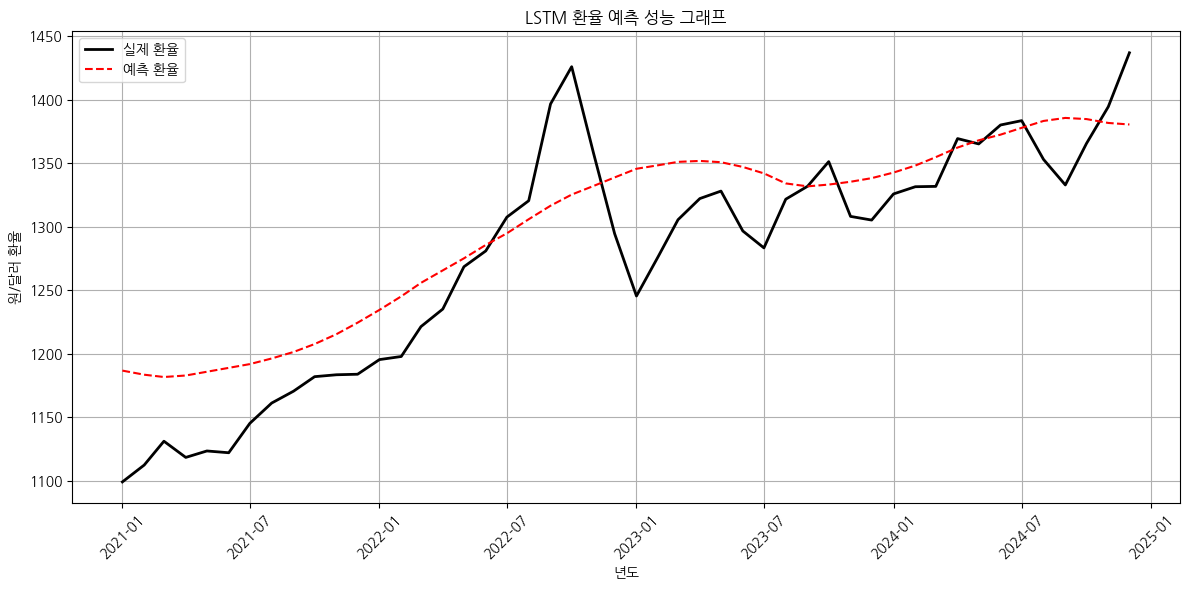

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

✅ Future 3-Month Forecasted Exchange Rates:
Month 1 (2025-01): 1379.8196 KRW/USD
Month 2 (2025-02): 1379.5753 KRW/USD
Month 3 (2025-03): 1378.2144 KRW/USD
Month 4 (2025-04): 1376.6702 KRW/USD
Month 5 (2025-05): 1377.2211 KRW/USD
Month 6 (2025-06): 1379.7686 KRW/USD
Month 7 (2025-07): 1382.1378 KRW/USD
Month 8 (2025-08): 1382.8679 KRW/USD
Month 9 (2025-09): 1384.0643 KRW/USD
Month 10 (2025-10): 1385.9124 KRW/USD
Month 11 (2025-11): 1388.1016 KRW/USD
Month 12 (2025-12): 1389.0015 KRW/USD
Month 13 (2026

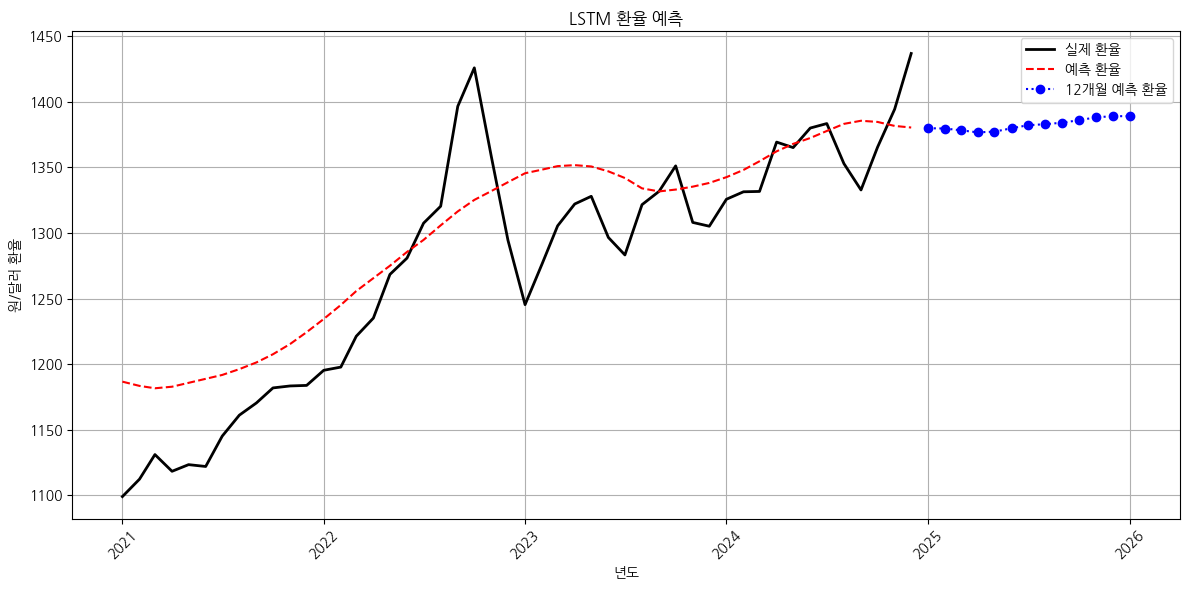

In [152]:
import os
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
from pandas.tseries.offsets import MonthBegin
import copy

# === 시드 고정 ===
def set_full_seed(seed=50):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

set_full_seed(50)

# === 데이터 준비 ===
features = ['경제 심리 지수', '한국 외환 보유액', 'vix', 'WTI 유가', '한국 실업률', '두바이 유가',
            'Brent 유가', '천연가스 가격', '유연탄 가격', '미국 주가지수',
            '한국 인플레이션율', '인플레이션 격차', '실질GDP성장률', 'M2',
            '금 가격', '구리 가격', '아연 가격', '알루미늄 가격', '니켈 가격',
            '외국인 투자 금액']
target = '원/달러환율'

X = df[features].ffill().bfill()
y = df[target].loc[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

def create_sequences(X, y, time_steps=12):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled)

# === baseline 모델 ===
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model.add(LSTM(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train_seq, y_train_seq, epochs=200, batch_size=16, validation_data=(X_test_seq, y_test_seq),
          callbacks=[early_stop], verbose=0)

y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test_seq)

baseline_rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))

# === Permutation Importance ===
importance_results = {}
for col_idx in range(X_test_scaled.shape[1]):
    X_test_perm = copy.deepcopy(X_test_seq)
    for i in range(X_test_perm.shape[0]):
        np.random.shuffle(X_test_perm[:, :, col_idx])

    y_pred_perm_scaled = model.predict(X_test_perm)
    y_pred_perm = scaler_y.inverse_transform(y_pred_perm_scaled)
    perm_rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_perm))
    importance = perm_rmse - baseline_rmse
    importance_results[col_idx] = importance

# 상위 10개 feature 선택
sorted_importance = sorted(importance_results.items(), key=lambda x: x[1], reverse=True)
top_10_indices = [idx for idx, _ in sorted_importance[:10]]
top_10_features = [features[idx] for idx in top_10_indices]

print("\n✅ Top 10 Important Features:")
for feat in top_10_features:
    print(f"- {feat}")

# === Top 10 feature로 모델 재학습 ===
X_train_top = X_train_scaled[:, top_10_indices]
X_test_top = X_test_scaled[:, top_10_indices]

X_train_seq_top, y_train_seq_top = create_sequences(X_train_top, y_train_scaled)
X_test_seq_top, y_test_seq_top = create_sequences(X_test_top, y_test_scaled)

model_top = Sequential()
model_top.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(X_train_seq_top.shape[1], X_train_seq_top.shape[2])))
model_top.add(LSTM(32, activation='relu'))
model_top.add(Dense(1))
model_top.compile(optimizer='adam', loss='mse')

model_top.fit(X_train_seq_top, y_train_seq_top, epochs=200, batch_size=16,
              validation_data=(X_test_seq_top, y_test_seq_top),
              callbacks=[early_stop], verbose=0)

y_pred_top_scaled = model_top.predict(X_test_seq_top)
y_pred_top = scaler_y.inverse_transform(y_pred_top_scaled)
y_test_actual_top = scaler_y.inverse_transform(y_test_seq_top)

rmse = np.sqrt(mean_squared_error(y_test_actual_top, y_pred_top))
mae = mean_absolute_error(y_test_actual_top, y_pred_top)
r2 = r2_score(y_test_actual_top, y_pred_top)

print(f"\n✅ Final Model Performance (Top 10 Features)")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

# === 성능 그래프 ===
test_dates_full = df.loc[X_test.index, 'TIME'].reset_index(drop=True)
test_dates = test_dates_full[12:]

plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_actual_top, label='실제 환율', color='black', linewidth=2)
plt.plot(test_dates, y_pred_top, label='예측 환율', linestyle='--', color='red')
plt.title('LSTM 환율 예측 성능 그래프')
plt.xlabel('년도')
plt.ylabel('원/달러 환율')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 미래 3개월 예측 ===
last_input_seq = X_test_top[-12:].reshape(1, 12, X_test_top.shape[1])
future_preds_scaled = []

for _ in range(13):
    future_pred_scaled = model_top.predict(last_input_seq)
    future_preds_scaled.append(future_pred_scaled[0])
    last_input_seq = np.append(last_input_seq[:, 1:, :], last_input_seq[:, -1:, :], axis=1)

future_preds = scaler_y.inverse_transform(np.array(future_preds_scaled))

# 미래 날짜 생성
last_date = pd.to_datetime(test_dates.iloc[-1])
future_dates = [last_date + MonthBegin(i) for i in range(1, 14)]
future_dates = pd.to_datetime(future_dates,format='%b-%y')

print("\n✅ Future 3-Month Forecasted Exchange Rates:")
for i, (date, pred) in enumerate(zip(future_dates, future_preds.flatten()), 1):
    print(f"Month {i} ({date.strftime('%Y-%m')}): {pred:.4f} KRW/USD")

# === 미래 예측 그래프 ===
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_actual_top, label='실제 환율', color='black', linewidth=2)
plt.plot(test_dates, y_pred_top, label='예측 환율', linestyle='--', color='red')
plt.plot(future_dates, future_preds, label='12개월 예측 환율', linestyle=':', color='blue', marker='o')
plt.title('LSTM 환율 예측')
plt.xlabel('년도')
plt.ylabel('원/달러 환율')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 미래 예측값 DataFrame 생성 ===
future_df = pd.DataFrame({
    'Month': [date.strftime('%Y-%m') for date in future_dates],
    'Predicted_Exchange_Rate': future_preds.flatten()
})

In [153]:
import pandas as pd

# 데이터 불러오기
df['TIME'] = pd.to_datetime(df['TIME'])

# Prophet에 맞는 포맷으로 변경: 'ds' = 날짜, 'y' = 예측 대상
df_prophet = df[['TIME', '철광석 가격']].rename(columns={
    'TIME': 'ds',
    '철광석 가격': 'y'
})

# 🔽 2000년 이후로 필터링
df_prophet = df_prophet[df_prophet['ds'] >= '2000-01-01']

# 결측치 보간 (중요!)
df_prophet['y'] = df_prophet['y'].fillna(method='ffill').fillna(method='bfill')


<ipython-input-153-f5815ec3030d>:16: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [154]:
model = Prophet()
model.fit(df_prophet)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc0bo_9e6/oc9xxyq4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc0bo_9e6/8geo65if.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38765', 'data', 'file=/tmp/tmpc0bo_9e6/oc9xxyq4.json', 'init=/tmp/tmpc0bo_9e6/8geo65if.json', 'output', 'file=/tmp/tmpc0bo_9e6/prophet_modelb59h02tb/prophet_model-20250512082014.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:20:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:20:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


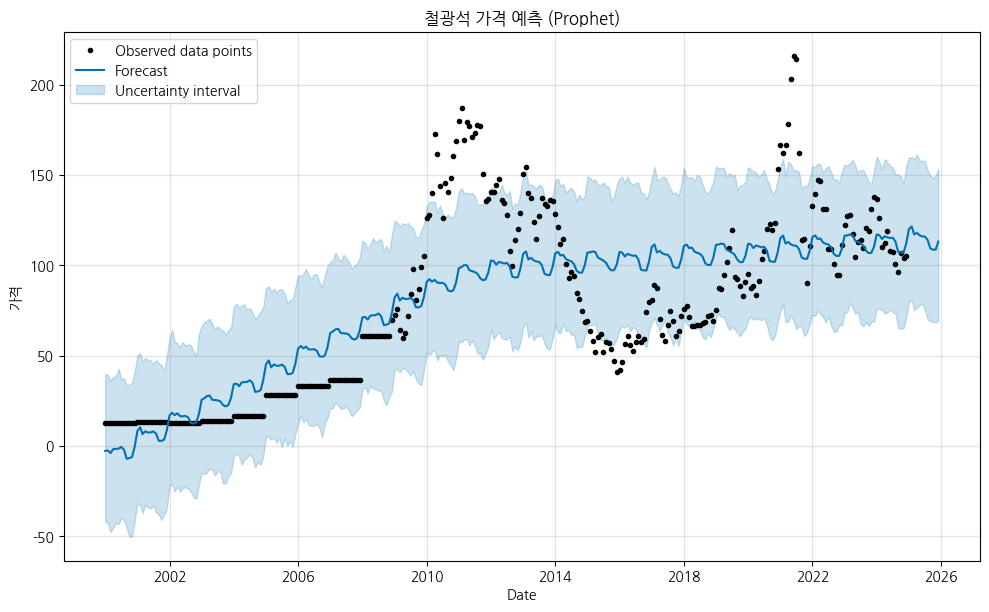

In [155]:
#12개월 이후까지 예측
future = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(future)

model.plot(forecast)
plt.title('철광석 가격 예측 (Prophet)')
plt.xlabel('Date')
plt.ylabel('가격')
plt.grid(True)
plt.legend()
plt.show()


- 검정 점: 실제
- 파란 선: 예측
- 파란 영역: 신뢰구간(95%)

In [156]:
# 1. forecast + 실제값 df_prophet merge
forecast_eval = pd.merge(
    forecast[['ds', 'yhat']],
    df_prophet[['ds', 'y']],
    on='ds',
    how='left'
)

# 2. 실제값 있는 구간만 남기기
#eval_df = forecast_eval.dropna(subset=['y'])
eval_df = forecast_eval

# 3. 최근 12개월 기준으로 tail
recent_12_months = eval_df.tail(24)
recent_12_months.reset_index(drop=True, inplace=True)

# 4. 결과 출력
print(recent_12_months)


           ds        yhat       y
0  2024-01-01  117.056777  136.59
1  2024-02-01  116.635842  125.93
2  2024-03-01  114.553545  110.19
3  2024-04-01  116.040221  112.23
4  2024-05-01  115.504677  119.24
5  2024-06-01  114.996160  108.10
6  2024-07-01  115.255107  107.39
7  2024-08-01  113.107674  100.91
8  2024-09-01  107.412898   96.24
9  2024-10-01  107.058567  106.61
10 2024-11-01  107.031764  103.98
11 2024-12-01  112.027935  105.34
12 2025-01-01  120.104942     NaN
13 2025-02-01  121.504489     NaN
14 2025-03-01  117.059366     NaN
15 2025-04-01  117.985364     NaN
16 2025-05-01  116.616908     NaN
17 2025-06-01  115.986513     NaN
18 2025-07-01  115.889614     NaN
19 2025-08-01  114.030407     NaN
20 2025-09-01  109.324734     NaN
21 2025-10-01  108.647633     NaN
22 2025-11-01  108.677030     NaN
23 2025-12-01  113.145135     NaN


In [157]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1. 실제값과 예측값 merge
forecast_eval = pd.merge(
    forecast[['ds', 'yhat']],
    df_prophet[['ds', 'y']],
    on='ds',
    how='left'
)

# 2. 2000년 이후로 필터링
forecast_eval = forecast_eval[forecast_eval['ds'] >= '2000-01-01']

# 3. 실제값 있는 구간만 비교
eval_df = forecast_eval.dropna(subset=['y'])

# 4. 성능 지표 계산
y_true = eval_df['y']
y_pred = eval_df['yhat']

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"📊 Prophet 철광석 가격 예측 성능:")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²  : {r2:.4f}")


📊 Prophet 철광석 가격 예측 성능:
MAE : 24.87
RMSE: 32.12
R²  : 0.5955


In [158]:
# 1. 실측 데이터 (최근 1년)
df_real = df[['TIME', '원/달러환율', '철광석 가격']]
df_real = df_real[(df_real['TIME'] >= '2024-01-01') & (df_real['TIME'] <= '2024-12-31')]
df_real = df_real.rename(columns={
    'TIME': 'ds',
    '원/달러환율': '환율',
    '철광석 가격': '철광석가격'
})

# 2. 예측 환율 (예: LSTM 기반)
df_fx_pred = pd.DataFrame({
    'ds': future_dates,                  # 월초 날짜 (2025-01 ~ 2025-03)
    '환율': future_preds.flatten()       # LSTM 예측 환율
})

# 3. 예측 철광석 가격 (Prophet 기반)
df_iron_pred = forecast[['ds', 'yhat']].iloc[-12:].reset_index(drop=True)
df_iron_pred = df_iron_pred.rename(columns={'yhat': '철광석가격'})

# 4. 예측 환율 + 철광석 가격 merge
df_pred = pd.merge(df_fx_pred, df_iron_pred, on='ds', how='inner')

# 5. 실측 + 예측 concat
df_combined = pd.concat([df_real, df_pred], ignore_index=True)

# ✅ 결과 확인
print(df_combined)


           ds           환율       철광석가격
0  2024-01-01  1325.670000  136.590000
1  2024-02-01  1331.370000  125.930000
2  2024-03-01  1331.630000  110.190000
3  2024-04-01  1369.250000  112.230000
4  2024-05-01  1365.050000  119.240000
5  2024-06-01  1379.950000  108.100000
6  2024-07-01  1383.370000  107.390000
7  2024-08-01  1352.870000  100.910000
8  2024-09-01  1332.760000   96.240000
9  2024-10-01  1365.370000  106.610000
10 2024-11-01  1394.320000  103.980000
11 2024-12-01  1436.780000  105.340000
12 2025-01-01  1379.819580  120.104942
13 2025-02-01  1379.575317  121.504489
14 2025-03-01  1378.214355  117.059366
15 2025-04-01  1376.670166  117.985364
16 2025-05-01  1377.221069  116.616908
17 2025-06-01  1379.768555  115.986513
18 2025-07-01  1382.137817  115.889614
19 2025-08-01  1382.867920  114.030407
20 2025-09-01  1384.064331  109.324734
21 2025-10-01  1385.912354  108.647633
22 2025-11-01  1388.101562  108.677030
23 2025-12-01  1389.001465  113.145135


In [159]:
df_combined['수입단가'] = df_combined['환율'] * df_combined['철광석가격']
df_combined['단가_변화율(%)'] = df_combined['수입단가'].pct_change() * 100
df_combined

,ds,환율,철광석가격,수입단가,단가_변화율(%)
0,2024-01-01,1325.670000,136.590000,181073.265300,NaN
1,2024-02-01,1331.370000,125.930000,167659.424100,-7.407963
2,2024-03-01,1331.630000,110.190000,146732.309700,-12.481920
3,2024-04-01,1369.250000,112.230000,153670.927500,4.728759
4,2024-05-01,1365.050000,119.240000,162768.562000,5.920205
5,2024-06-01,1379.950000,108.100000,149172.595000,-8.352944
6,2024-07-01,1383.370000,107.390000,148560.104300,-0.410592
7,2024-08-01,1352.870000,100.910000,136518.111700,-8.105805
8,2024-09-01,1332.760000,96.240000,128264.822400,-6.045564
9,2024-10-01,1365.370000,106.610000,145562.095700,13.485594


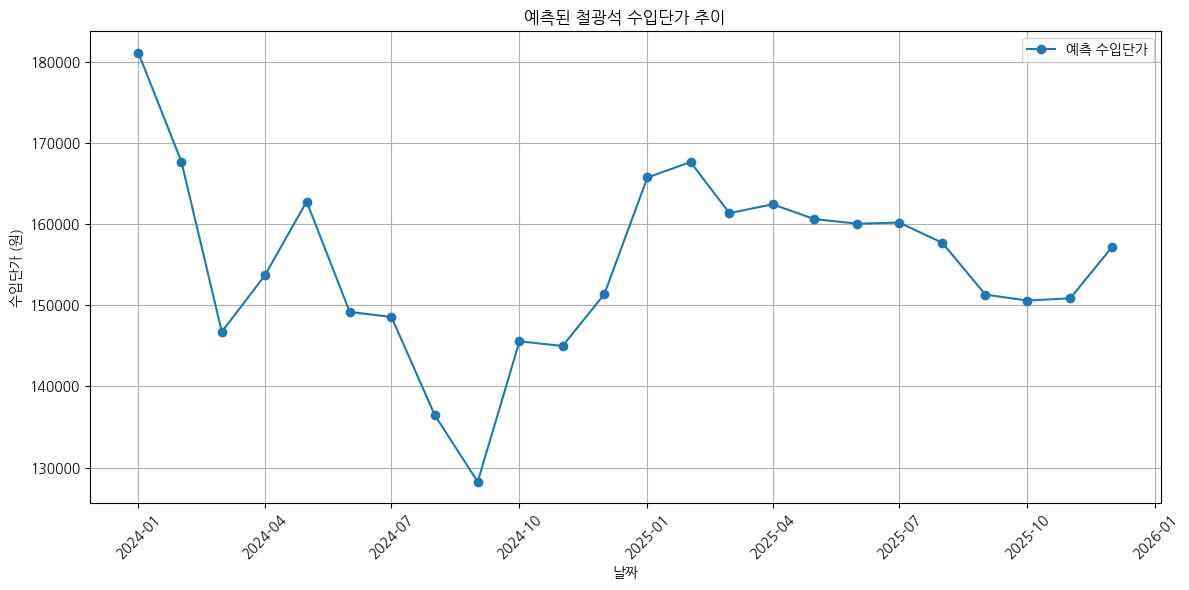

,ds,환율,철광석가격,수입단가,단가_변화율(%)
0,2024-01-01,1325.670000,136.590000,181073.265300,NaN
1,2024-02-01,1331.370000,125.930000,167659.424100,-7.407963
2,2024-03-01,1331.630000,110.190000,146732.309700,-12.481920
3,2024-04-01,1369.250000,112.230000,153670.927500,4.728759
4,2024-05-01,1365.050000,119.240000,162768.562000,5.920205
5,2024-06-01,1379.950000,108.100000,149172.595000,-8.352944
6,2024-07-01,1383.370000,107.390000,148560.104300,-0.410592
7,2024-08-01,1352.870000,100.910000,136518.111700,-8.105805
8,2024-09-01,1332.760000,96.240000,128264.822400,-6.045564
9,2024-10-01,1365.370000,106.610000,145562.095700,13.485594


In [160]:
import matplotlib.pyplot as plt

# 수입단가 시계열 그래프
plt.figure(figsize=(12,6))
plt.plot(df_combined['ds'], df_combined['수입단가'], marker='o', label='예측 수입단가')
plt.title('예측된 철광석 수입단가 추이')
plt.xlabel('날짜')
plt.ylabel('수입단가 (원)')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 결과 테이블 확인
df_combined

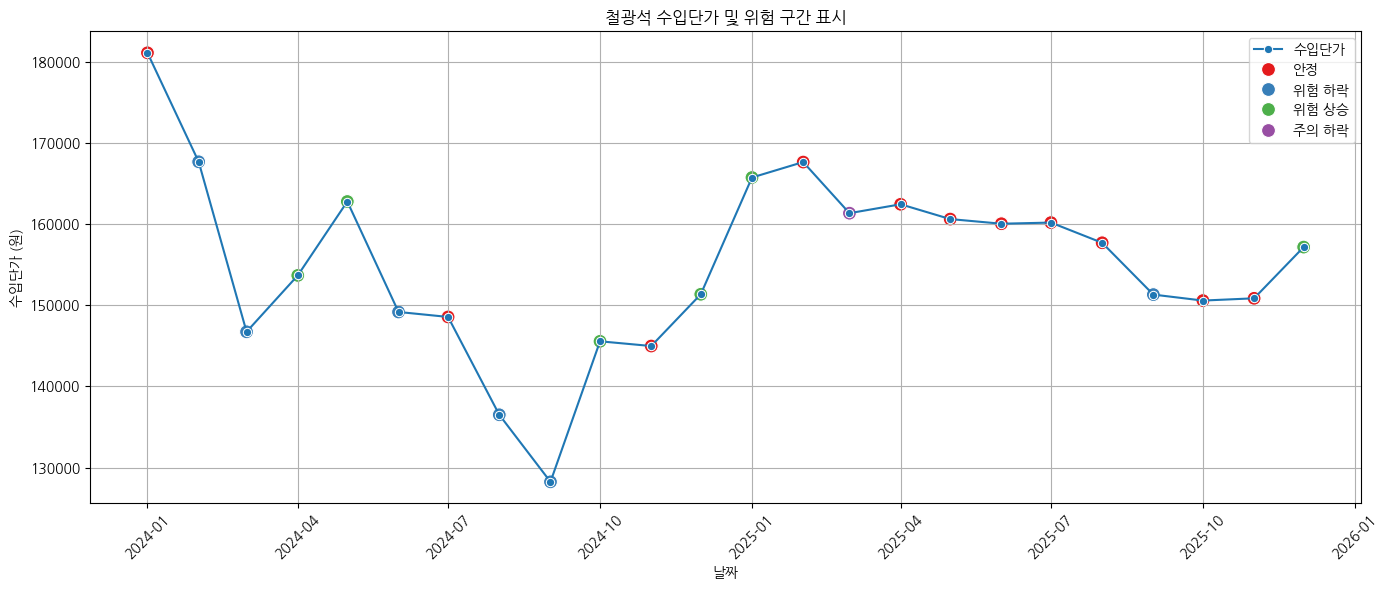

In [161]:
def classify_risk(change):
    if change >= 4:
        return '위험 상승'
    elif change >= 2:
        return '주의 상승'
    elif change <= -4:
        return '위험 하락'
    elif change <= -2:
        return '주의 하락'
    else:
        return '안정'

# 변화율 계산
df_combined['수입단가_변화율(%)'] = df_combined['수입단가'].pct_change() * 100

# 위험 구간 분류
df_combined['위험구간'] = df_combined['수입단가_변화율(%)'].apply(classify_risk)

# 결과 확인
df_combined[['ds', '수입단가', '수입단가_변화율(%)', '위험구간']].tail(12)

import seaborn as sns

plt.figure(figsize=(14,6))
sns.lineplot(data=df_combined, x='ds', y='수입단가', marker='o', label='수입단가')
sns.scatterplot(data=df_combined, x='ds', y='수입단가', hue='위험구간', palette='Set1', s=100)
plt.title('철광석 수입단가 및 위험 구간 표시')
plt.xlabel('날짜')
plt.ylabel('수입단가 (원)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


주의, 위험 구간을 2와 4로 선정한 이유:
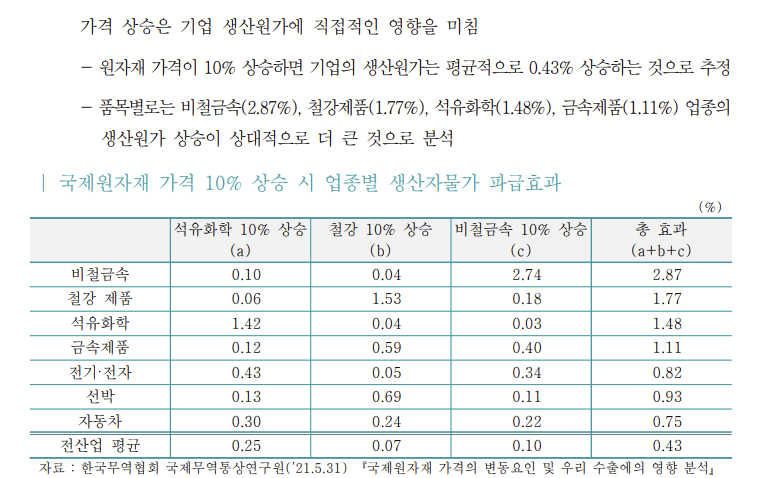


이 기준은 산업별 물가 파급효과를 다룬 논문 자료에서,
원자재 가격 10% 상승 시 생산자물가가 평균 0.43%, 일부 업종은 2~3% 이상 상승하는 것으로 나타난 점을 참고하였다.
이는 실제 기업의 생산비, 계약 전략, 구매 타이밍에 직접적인 영향을 주는 구간으로,
예측 시스템을 통한 조기 경고 및 대응 전략 수립에 유효하다고 판단된다.

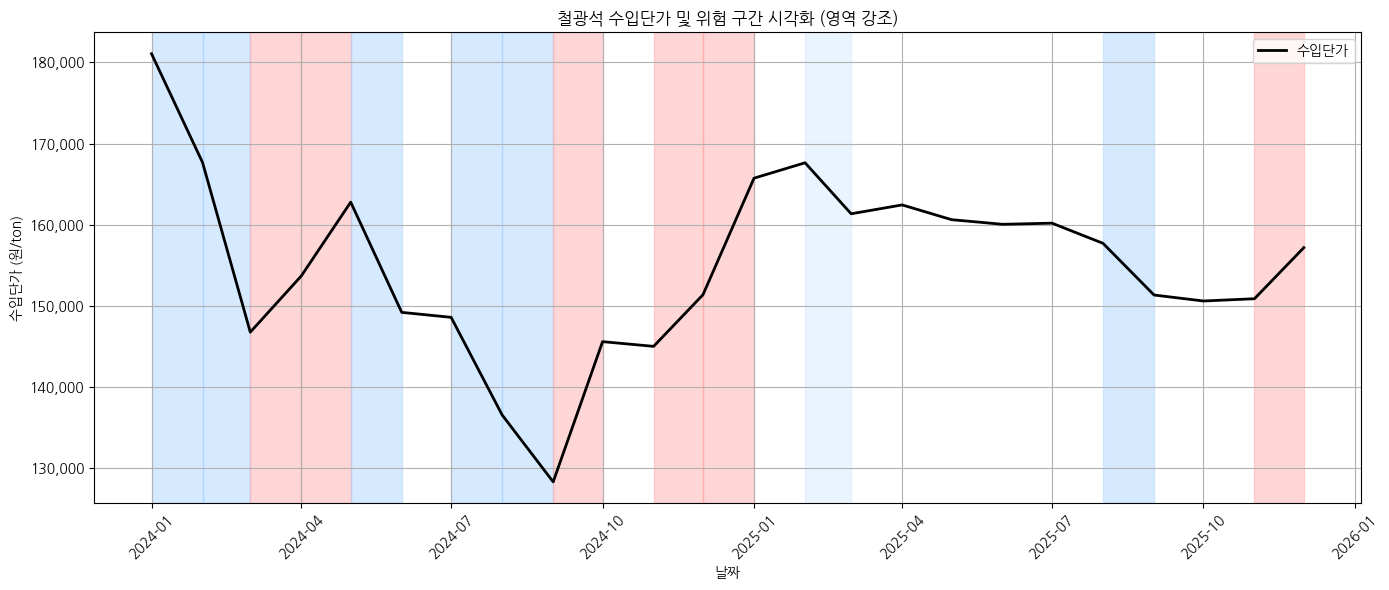

In [162]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure(figsize=(14,6))

# 수입단가 추이선
plt.plot(df_combined['ds'], df_combined['수입단가'], label='수입단가', color='black', linewidth=2)

# risk 범위 설정
def classify_risk(change):
    if change >= 4:
        return '위험 상승'
    elif change >= 2:
        return '주의 상승'
    elif change <= -4:
        return '위험 하락'
    elif change <= -2:
        return '주의 하락'
    else:
        return '안정'

# 색깔 영역 지정
for i in range(1, len(df_combined)):
    x_start = df_combined['ds'].iloc[i-1]
    x_end = df_combined['ds'].iloc[i]
    risk = df_combined['위험구간'].iloc[i]

    if risk == '위험 상승':
        color = '#ff9999'  # 빨강
    elif risk == '주의 상승':
        color = '#ffe6cc'  # 주황
    elif risk == '주의 하락':
        color = '#cce5ff'  # 파랑
    elif risk == '위험 하락':
        color = '#99ccff'  # 진한 파랑
    else:
        continue

    plt.axvspan(x_start, x_end, color=color, alpha=0.4)

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))


# 레이블 및 기타
plt.title('철광석 수입단가 및 위험 구간 시각화 (영역 강조)')
plt.xlabel('날짜')
plt.ylabel('수입단가 (원/ton)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(['수입단가'])
plt.tight_layout()
plt.show()

In [163]:
import plotly.graph_objects as go
import pandas as pd

# 예측 기준일
예측시작일 = pd.to_datetime("2025-01-01")
df_combined['예측여부'] = df_combined['ds'] >= 예측시작일

# Plot 생성
fig = go.Figure()

# ▶ 수입단가 선
fig.add_trace(go.Scatter(
    x=df_combined['ds'],
    y=df_combined['수입단가'],
    mode='lines',
    line=dict(color='black'),
    name='',
    hoverinfo='skip'
))

# ▶ 색칠 영역: 현재 시점부터 다음 시점까지 (경고 시작점으로 직관적으로 보이도록 수정)
for i in range(len(df_combined)):
    x_start = df_combined['ds'].iloc[i-1]
    x_end = df_combined['ds'].iloc[i]
    risk = df_combined['위험구간'].iloc[i]

    if risk == '위험 상승':
        color = '#ffcccc'  # 연분홍
    elif risk == '주의 상승':
        color = '#ffe5cc'  # 연살구
    elif risk == '주의 하락':
        color = '#e0ecff'  # 연하늘
    elif risk == '위험 하락':
        color = '#c7dcff'  # 중하늘
    else:
        continue

    fig.add_vrect(
        x0=x_start, x1=x_end,
        fillcolor=color,
        opacity=0.3,
        line_width=0
    )

# ▶ Hover 텍스트
hover_text = []
for i, row in df_combined.iterrows():
    risk = row['위험구간']
    if '위험' in risk:
        risk_display = f"<b><span style='color:red'>{risk}</span></b>"
    elif '주의' in risk:
        risk_display = f"<b><span style='color:orange'>{risk}</span></b>"
    else:
        risk_display = f"<span style='color:blue'>안정</span>"

    if row['예측여부']:
        hover_text.append(
            f"<b>{row['ds'].strftime('%Y-%m')}</b><br>"
            f"{risk_display}<br>"
            f"예측 환율: {row['환율']:,.2f} 원<br>"
            f"예측 철광석 가격: {row['철광석가격']:,.2f} USD<br>"
            f"예측 수입단가: {row['수입단가']:,.2f} 원<br>"
            f"예측 변화율: {row['수입단가_변화율(%)']:.2f}% (전월 대비)"
        )
    else:
        hover_text.append(
            f"<b>{row['ds'].strftime('%Y-%m')}</b><br>"
            f"{risk_display}<br>"
            f"환율: {row['환율']:,.2f} 원<br>"
            f"철광석 가격: {row['철광석가격']:,.2f} USD<br>"
            f"수입단가: {row['수입단가']:,.2f} 원<br>"
            f"변화율: {row['수입단가_변화율(%)']:.2f}% (전월 대비)"
        )

# ▶ Hover 점 표시
fig.add_trace(go.Scatter(
    x=df_combined['ds'],
    y=df_combined['수입단가'],
    mode='markers',
    marker=dict(color='black', size=6),
    text=hover_text,
    hoverinfo='text',
    name='',
    showlegend=False
))

# ▶ 기준선: 예측 시작
fig.add_vline(x=예측시작일, line_dash='dot', line_color='black')

# ▶ 축 설정
fig.update_yaxes(title='수입단가 (원)', tickformat=",", showgrid=True)
fig.update_xaxes(title='날짜', showgrid=True)

# ▶ 전체 레이아웃
fig.update_layout(
    title='철광석 수입단가 및 변화율 기반 위험 구간 (최종 Plotly)',
    hovermode='x unified',
    template='simple_white',
    height=500
)

fig.show()


2024년 11월부터 2025년 1월까지의 구간에서는 철광석 수입단가가 약 10% 가까이 급등하는 것으로 예측됩니다.

이에 따라 본 분석은 다음과 같은 전략적 시사점을 제안합니다:

- 단기적으로는 선물계약 또는 조기 구매를 통해 고점 회피 전략을 고려



---

